### Testing Prophet on mobile timeseries data

In [1]:
# import Prophet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from fbprophet import Prophet
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)

In [3]:
agg_by_cell = df.groupby(by = df['cell_num'])
count = 0
for i,k in agg_by_cell: 
    print(i, k)
    count += 1
    if count > 1: break

486-1252                date  cell_num  nr_people  hours  minutes
0        2017-04-16  486-1252       36.0    0.0      0.0
221      2017-04-16  486-1252       36.0    0.0     15.0
442      2017-04-16  486-1252       34.0    0.0     30.0
663      2017-04-16  486-1252       33.0    0.0     45.0
884      2017-04-16  486-1252       32.0    1.0      0.0
...             ...       ...        ...    ...      ...
2608463  2017-08-16  486-1252       41.0   22.0     45.0
2608684  2017-08-16  486-1252       40.0   23.0      0.0
2608905  2017-08-16  486-1252       39.0   23.0     15.0
2609126  2017-08-16  486-1252       40.0   23.0     30.0
2609347  2017-08-16  486-1252       40.0   23.0     45.0

[11808 rows x 5 columns]
486-1253                date  cell_num  nr_people  hours  minutes
1        2017-04-16  486-1253       39.0    0.0      0.0
222      2017-04-16  486-1253       38.0    0.0     15.0
443      2017-04-16  486-1253       36.0    0.0     30.0
664      2017-04-16  486-1253       35.0    

In [4]:
celldata = agg_by_cell.get_group('486-1264')
celldata.head()

,date,cell_num,nr_people,hours,minutes
12,2017-04-16,486-1264,373.0,0.0,0.0
233,2017-04-16,486-1264,368.0,0.0,15.0
454,2017-04-16,486-1264,363.0,0.0,30.0
675,2017-04-16,486-1264,351.0,0.0,45.0
896,2017-04-16,486-1264,343.0,1.0,0.0


In [5]:
# Prophet needs data in the following format  YYYY-MM-DD HH:MM:SS

celldata.shape

(11808, 5)

In [6]:
dates4prophet = []
cell_values = []
count = 0
for index, row in celldata.iterrows():
    
    date = row['date']
    h = str(row['hours'])
   
    h = h.split('.')
    
    if len(h[0])<2:
        h = h[1]+h[0]
    else: 
        h = h[0]
   
    minutes = str(row['minutes'])
    m = ''
    minutes = minutes.split('.')
    if len(minutes[0])<2: 
        m = minutes[0] +'0'
    else: 
        m = minutes[0]
    #print(date, h, m)
    data_f = date+' '+h+':'+m+':'+'00'
    #print(data_f)
    cell_values.append(row['nr_people'])
    dates4prophet.append(data_f)

In [7]:
di = {'ds': dates4prophet, 'y':cell_values}

In [8]:
data4prophet = pd.DataFrame(di)
data4prophet.shape
print(data4prophet.head())
#train, test = data4prophet[:10000], data4prophet[10000:]

                    ds      y
0  2017-04-16 00:00:00  373.0
1  2017-04-16 00:15:00  368.0
2  2017-04-16 00:30:00  363.0
3  2017-04-16 00:45:00  351.0
4  2017-04-16 01:00:00  343.0


In [9]:
# fit the model
m = Prophet(changepoint_prior_scale=0.01).fit(data4prophet)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [10]:
# make predictions
# 28 / 4 = 952 sono il numero di ore in avanti che Prophet deve predire
future = m.make_future_dataframe(periods=0, freq='H')

In [11]:
future.tail()

,ds
11803,2017-08-16 22:45:00
11804,2017-08-16 23:00:00
11805,2017-08-16 23:15:00
11806,2017-08-16 23:30:00
11807,2017-08-16 23:45:00


In [12]:
# make forcast and visualize plot
fcast = m.predict(future)

In [13]:
len(fcast)


11808

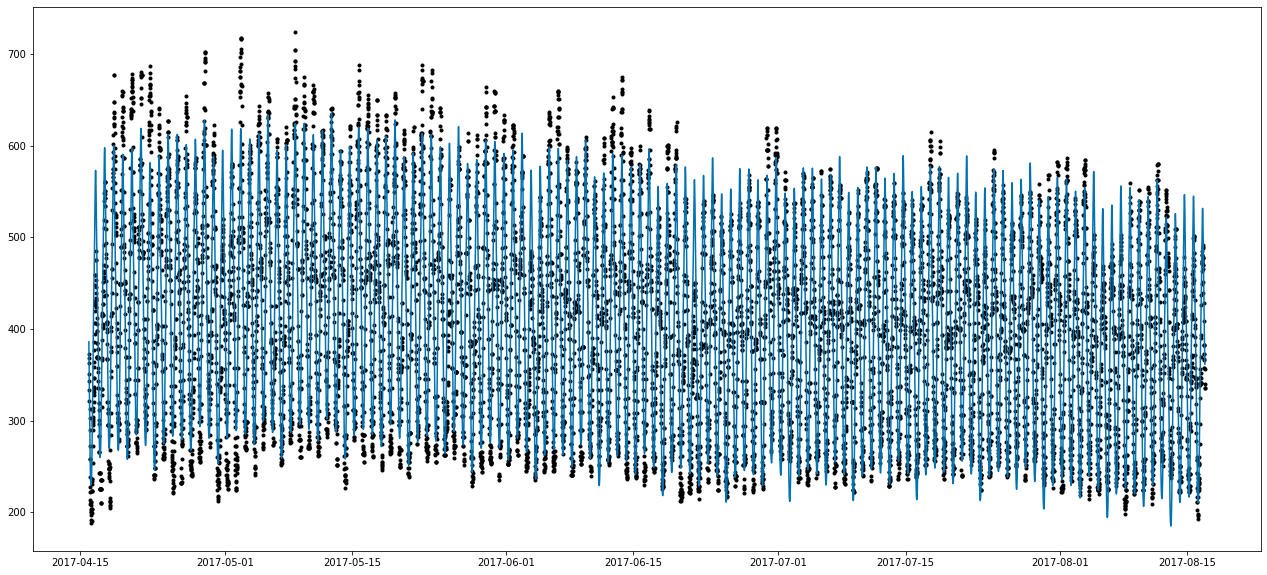

In [14]:
figsize=(22, 10)
xlabel='ds'
ylabel='y'
fig = plt.figure(facecolor='w', figsize=figsize)

ax = fig.add_subplot(111)

fcast_t = fcast['ds'].dt.to_pydatetime()
ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.')
ax.plot(fcast_t, fcast['yhat'], ls='-', c='#0072B2')
plt.show()

In [15]:
fcast[['ds', 'trend', 'yhat', 'yhat_upper', 'yhat_lower']].head(10)

,ds,trend,yhat,yhat_upper,yhat_lower
0,2017-04-16 00:00:00,410.463684,386.071126,430.970397,345.385099
1,2017-04-16 00:15:00,410.490856,377.877851,423.366285,331.115111
2,2017-04-16 00:30:00,410.518027,368.999544,412.523974,321.388903
3,2017-04-16 00:45:00,410.545198,359.490450,405.557125,314.748187
4,2017-04-16 01:00:00,410.572370,349.447378,396.483664,303.107273
5,2017-04-16 01:15:00,410.599541,339.003341,387.286190,293.255254
6,2017-04-16 01:30:00,410.626713,328.319124,373.817391,283.687170
7,2017-04-16 01:45:00,410.653884,317.573425,363.509509,273.092575
8,2017-04-16 02:00:00,410.681055,306.952273,353.635396,259.587816
9,2017-04-16 02:15:00,410.708227,296.638470,341.590639,249.598902


In [16]:
print(len(fcast))

11808


In [17]:
yhat = fcast[11780:]
data4prophet_y = data4prophet[11780:]
y = data4prophet_y['y'].values
yhat = np.rint(yhat['yhat'].values)
print(len(yhat))
print(len(y))

28
28


In [18]:
print(y[0:10])
print(yhat[0:10])

[481. 481. 488. 492. 490. 478. 470. 470. 477. 479.]
[526. 529. 531. 532. 530. 527. 522. 515. 507. 499.]


In [19]:
difference = abs(y - yhat)

Mean Absolute Error =  37.107142857142854


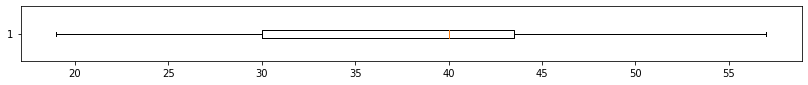

In [20]:
# show boxplot
plt.figure(figsize = (14,1))
plt.boxplot(difference, vert= False);
print('Mean Absolute Error = ', np.mean(difference))

### Calcolo per tutte le celle

0


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


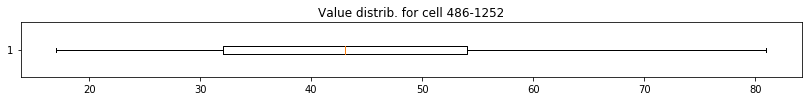

9008
Mean Absolute Error =  3.7595629246765774


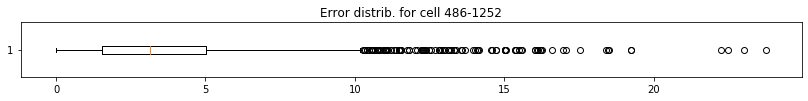

1


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


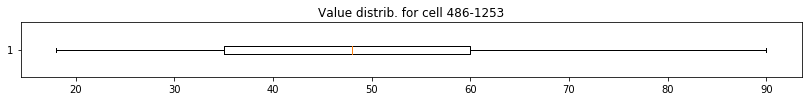

9008
Mean Absolute Error =  4.2641526237059795


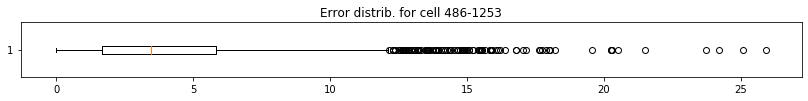

2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


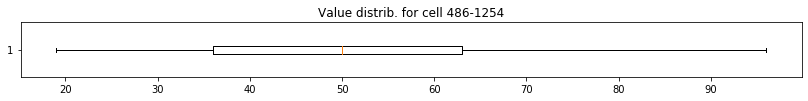

9008
Mean Absolute Error =  4.566985614590083


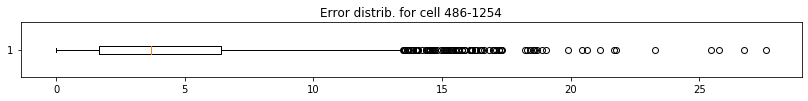

3


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


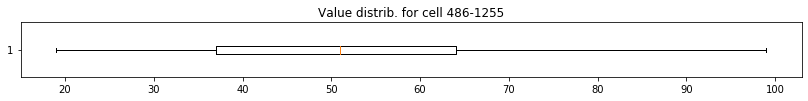

9008
Mean Absolute Error =  4.7361193774693895


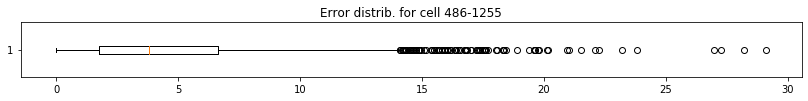

4


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


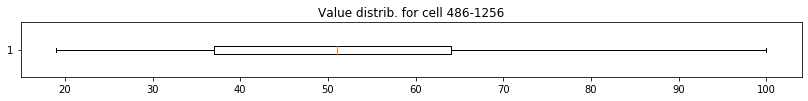

9008
Mean Absolute Error =  4.77030281441429


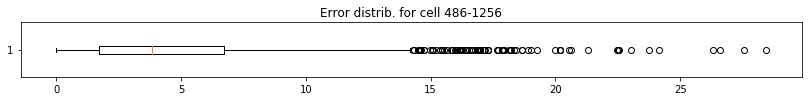

5


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


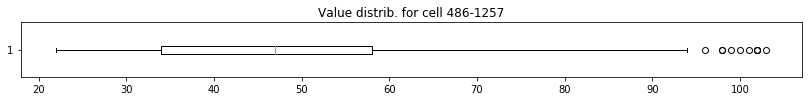

9008
Mean Absolute Error =  3.6245819092983447


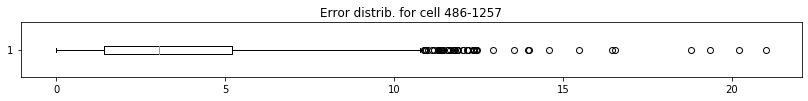

6


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


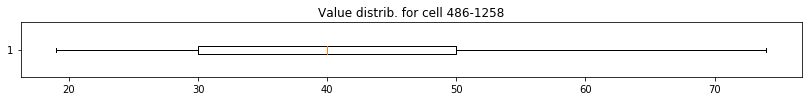

9008
Mean Absolute Error =  2.650813650827581


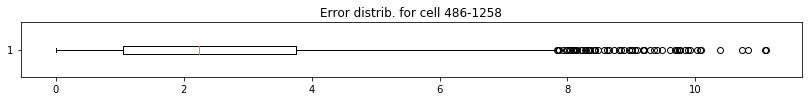

7


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


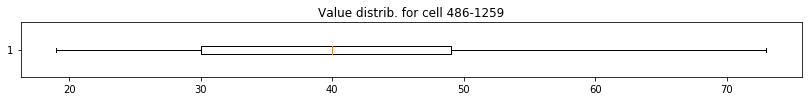

9008
Mean Absolute Error =  2.605775049818797


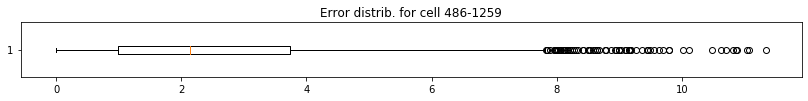

8


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


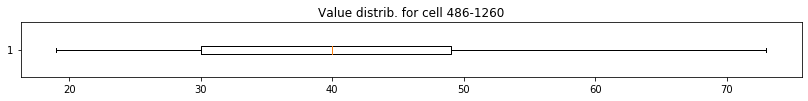

9008
Mean Absolute Error =  2.585587487765631


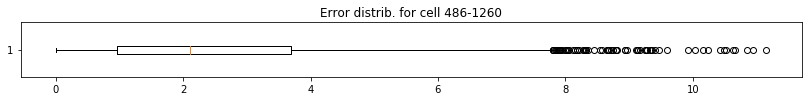

9


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


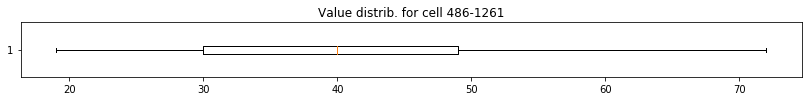

9008
Mean Absolute Error =  2.5645798624843255


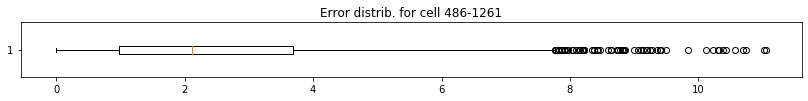

10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


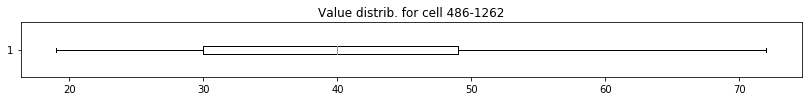

9008
Mean Absolute Error =  2.530989238457113


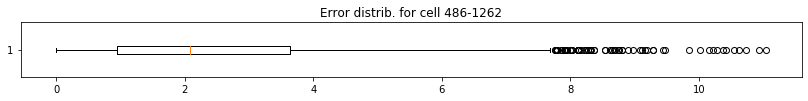

11


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


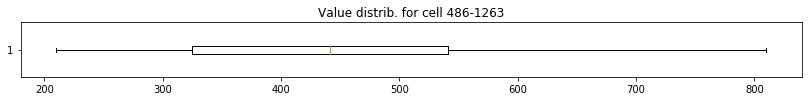

9008
Mean Absolute Error =  27.938624395833322


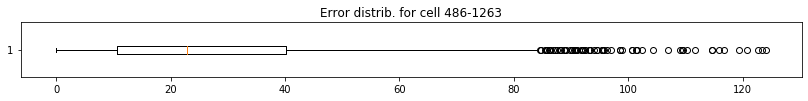

12


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


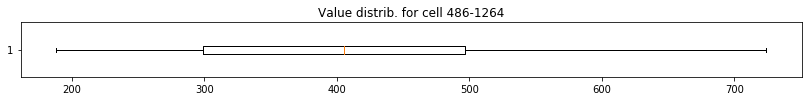

9008
Mean Absolute Error =  25.440713006712674


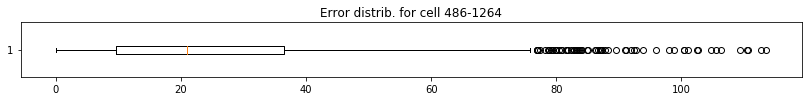

13


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


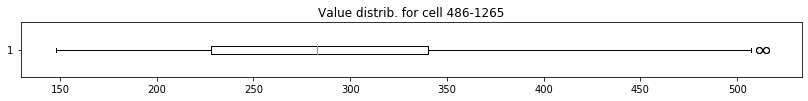

9008
Mean Absolute Error =  22.595340145189628


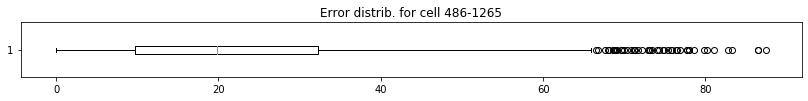

14


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


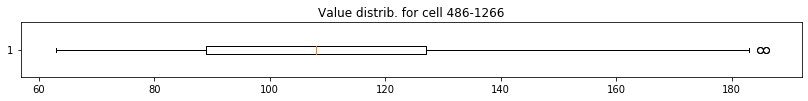

9008
Mean Absolute Error =  7.692936772277212


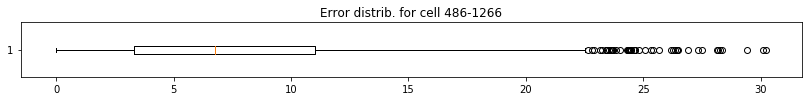

15


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


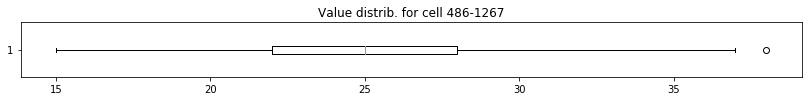

9008
Mean Absolute Error =  1.6670283336393237


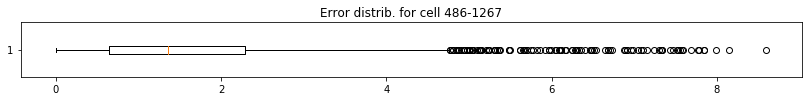

16


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


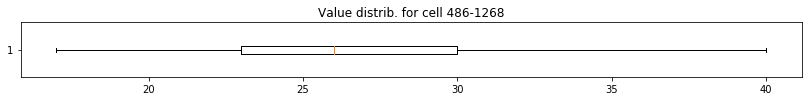

9008
Mean Absolute Error =  1.5789761054136582


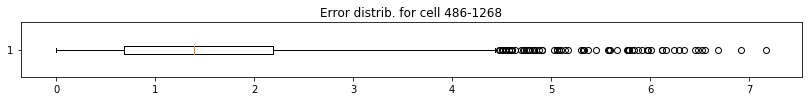

17


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


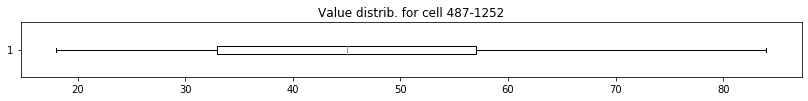

9008
Mean Absolute Error =  3.9256850528894374


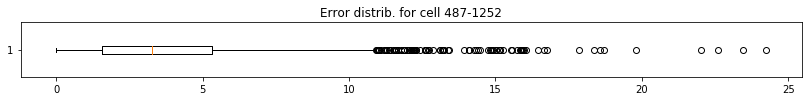

18


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


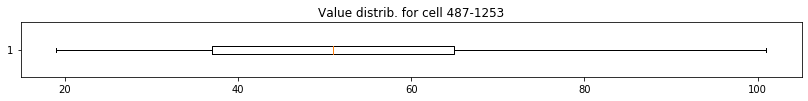

9008
Mean Absolute Error =  4.840608893696407


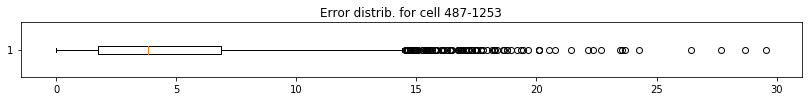

19


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


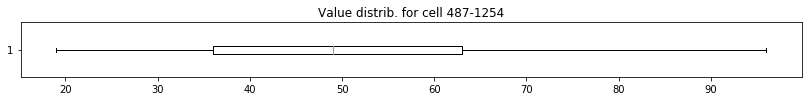

9008
Mean Absolute Error =  4.589804810916867


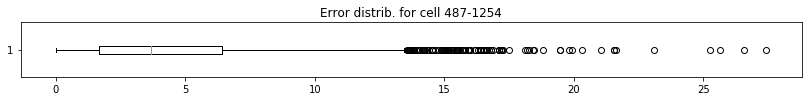

20


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


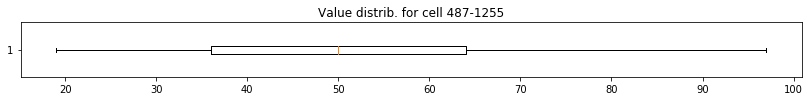

9008
Mean Absolute Error =  4.669278634290368


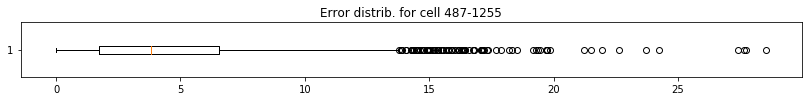

21


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


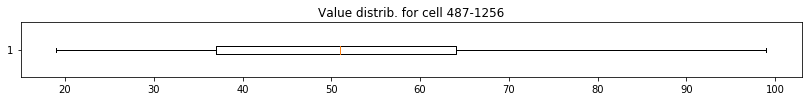

9008
Mean Absolute Error =  4.70585067767068


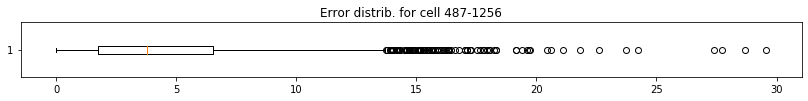

22


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


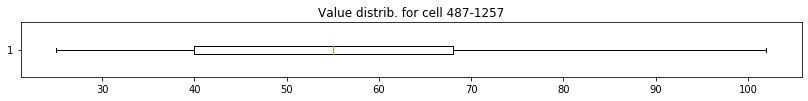

9008
Mean Absolute Error =  4.764889873155622


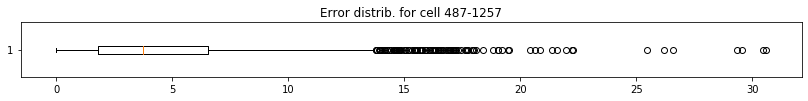

23


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


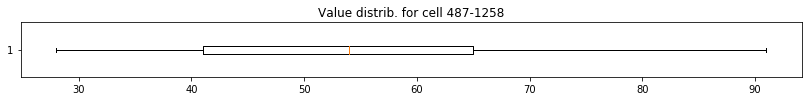

9008
Mean Absolute Error =  3.1022174070978163


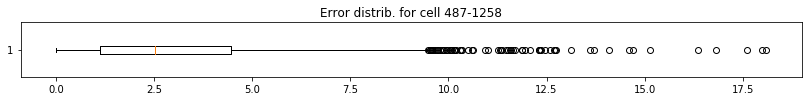

24


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


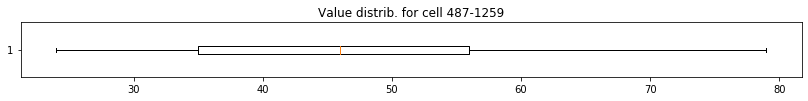

9008
Mean Absolute Error =  2.7111861019635457


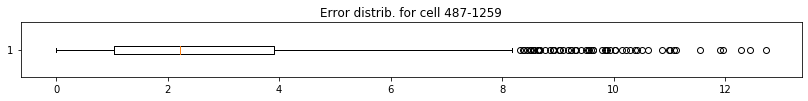

25


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


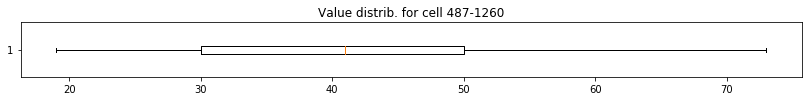

9008
Mean Absolute Error =  2.6127849424982874


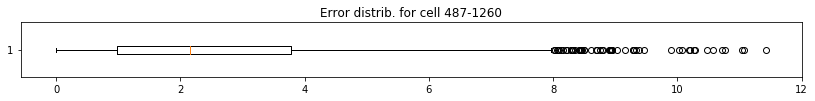

26


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


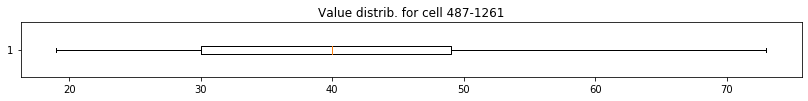

9008
Mean Absolute Error =  2.618152817946531


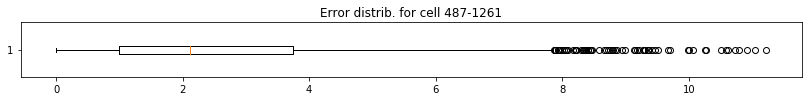

27


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


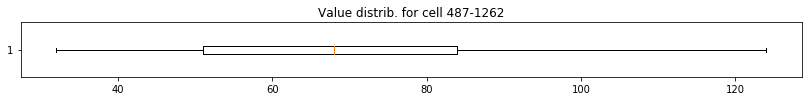

9008
Mean Absolute Error =  4.45988270059695


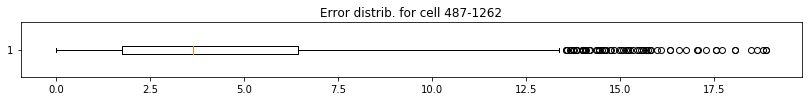

28


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


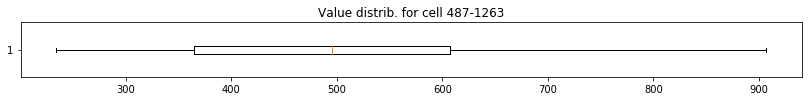

9008
Mean Absolute Error =  31.95015565167577


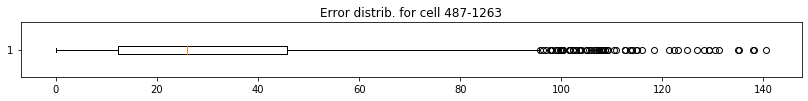

29


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


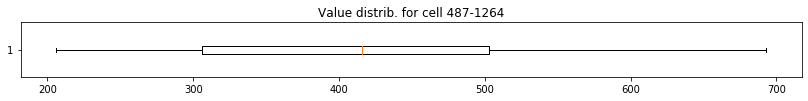

9008
Mean Absolute Error =  25.33990828243753


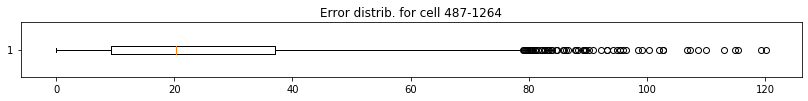

30


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


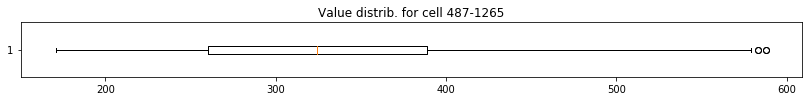

9008
Mean Absolute Error =  25.559406206418224


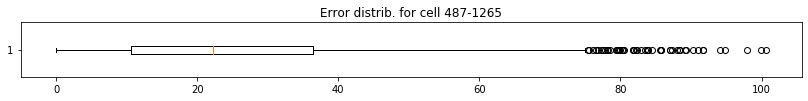

31


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


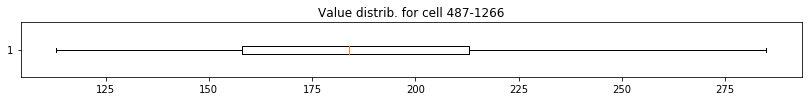

9008
Mean Absolute Error =  10.917205344461953


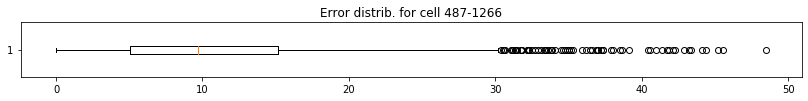

32


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


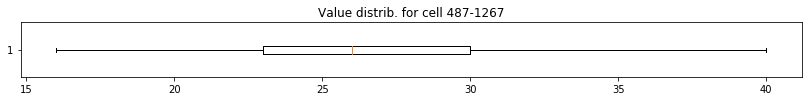

9008
Mean Absolute Error =  1.6774164578848354


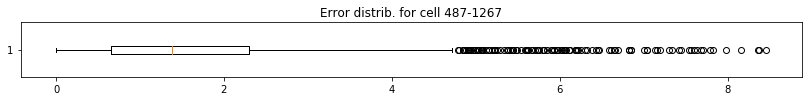

33


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


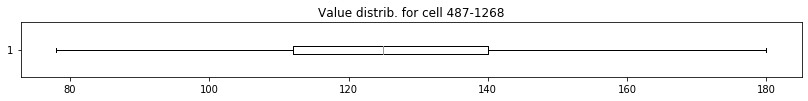

9008
Mean Absolute Error =  7.901163582181858


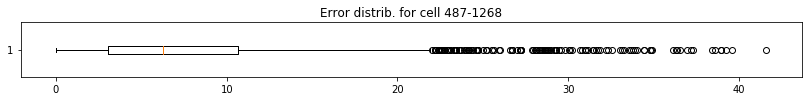

34


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


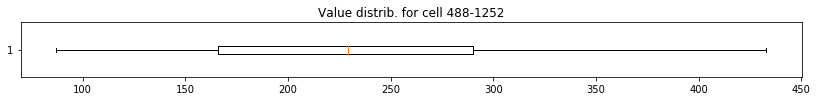

9008
Mean Absolute Error =  20.92060607744641


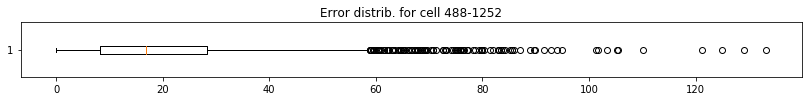

35


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


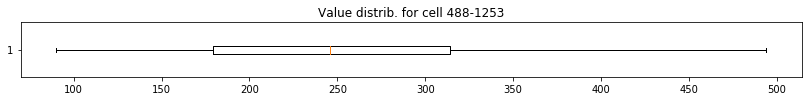

9008
Mean Absolute Error =  23.759363980064922


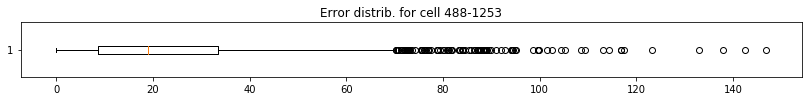

36


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


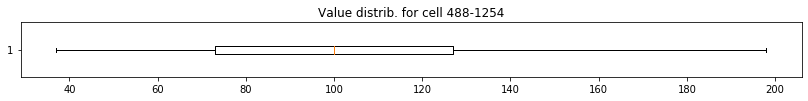

9008
Mean Absolute Error =  9.47797214999407


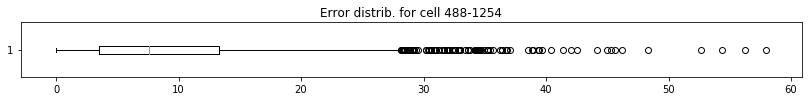

37


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


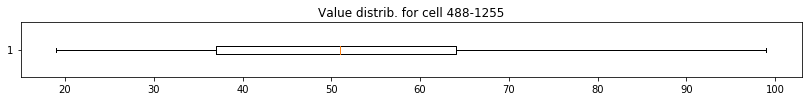

9008
Mean Absolute Error =  4.721489920133694


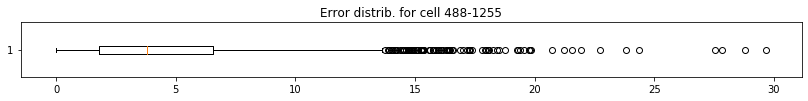

38


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


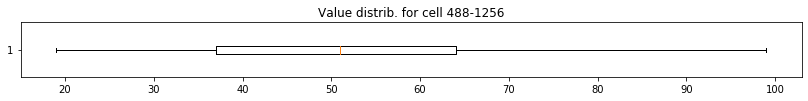

9008
Mean Absolute Error =  4.69376362531977


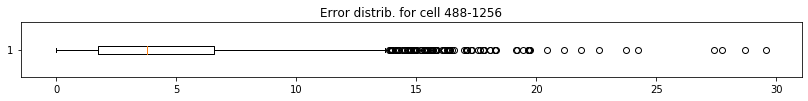

39


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


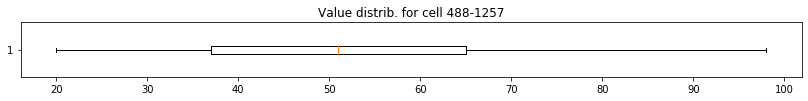

9008
Mean Absolute Error =  4.672525467108514


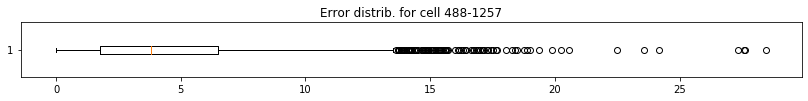

40


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


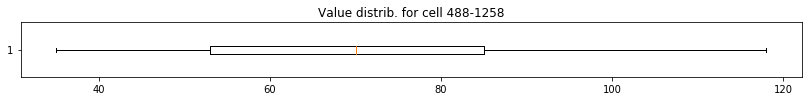

9008
Mean Absolute Error =  5.025314193853702


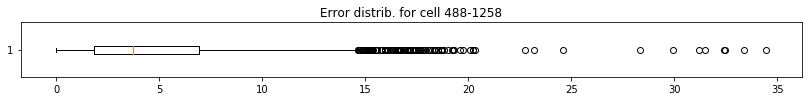

41


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


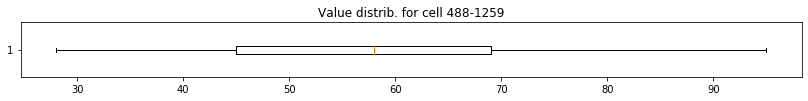

9008
Mean Absolute Error =  3.3765115778797363


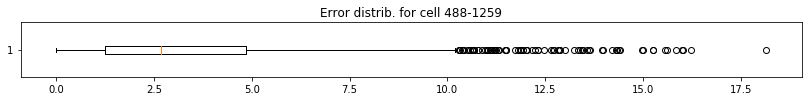

42


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


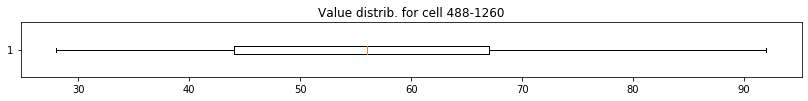

9008
Mean Absolute Error =  3.2313906009969053


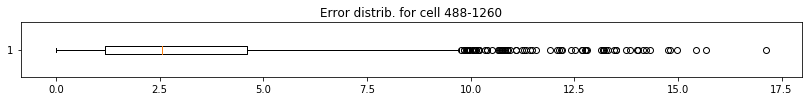

43


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


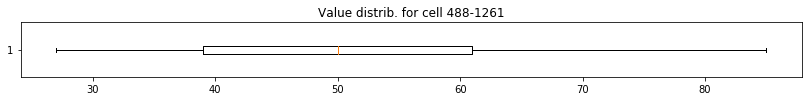

9008
Mean Absolute Error =  2.88130128825821


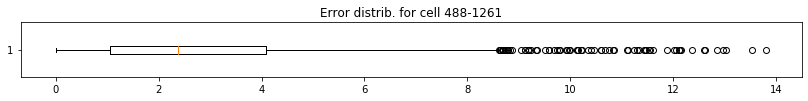

44


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


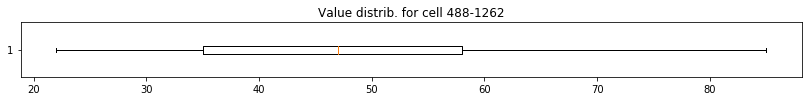

9008
Mean Absolute Error =  3.0708695432436377


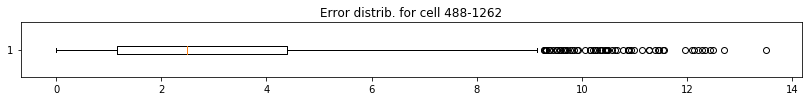

45


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


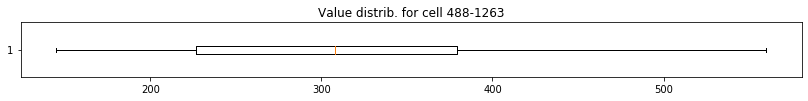

9008
Mean Absolute Error =  20.22888214925958


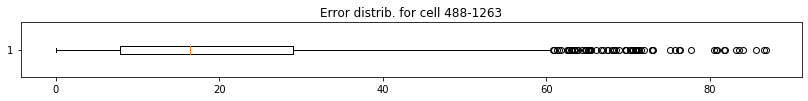

46


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


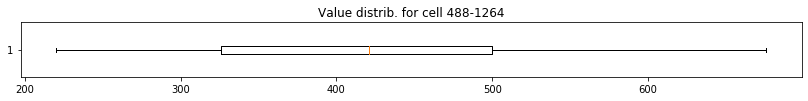

9008
Mean Absolute Error =  24.220015386914802


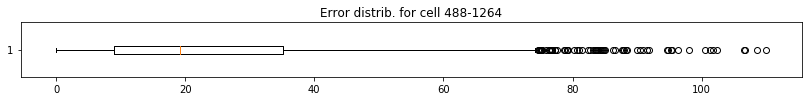

47


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


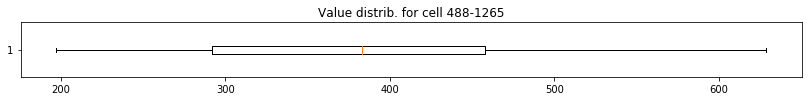

9008
Mean Absolute Error =  22.15055702948776


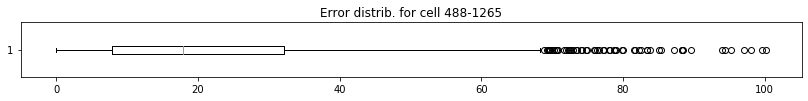

48


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


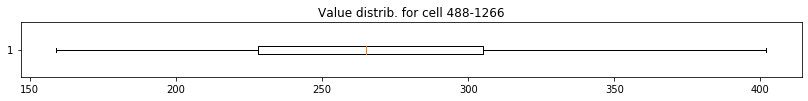

9008
Mean Absolute Error =  14.845493495437502


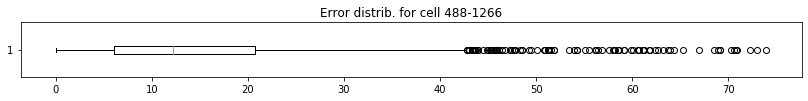

49


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


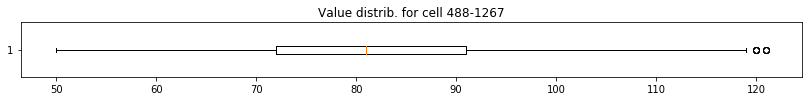

9008
Mean Absolute Error =  4.8985201899216255


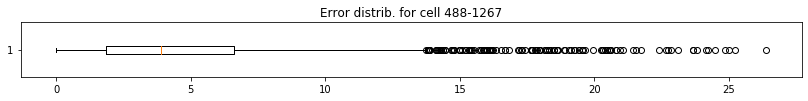

50


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


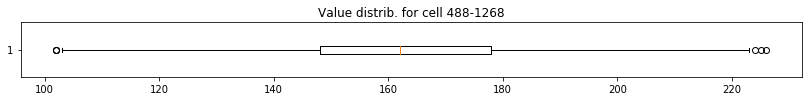

9008
Mean Absolute Error =  9.91318435799394


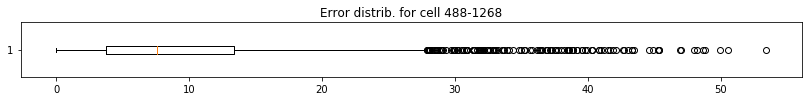

51


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


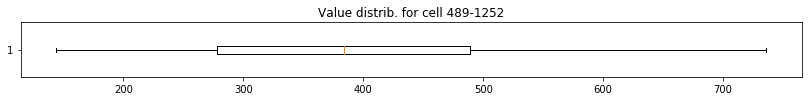

9008
Mean Absolute Error =  36.02792377015729


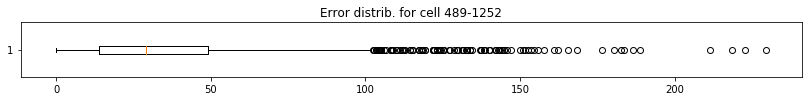

52


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


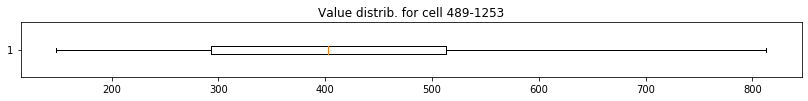

9008
Mean Absolute Error =  39.35517185694003


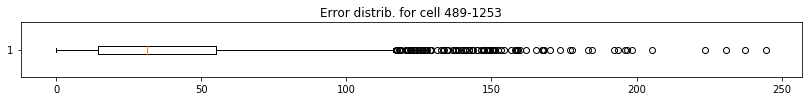

53


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


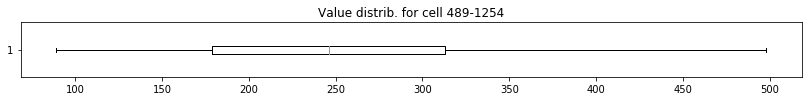

9008
Mean Absolute Error =  23.770246412741372


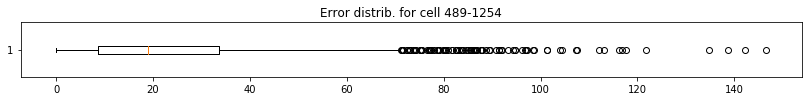

54


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


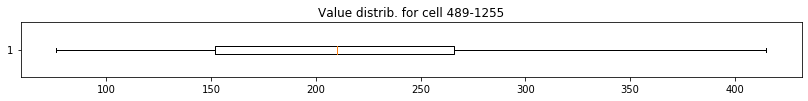

9008
Mean Absolute Error =  19.813204540964378


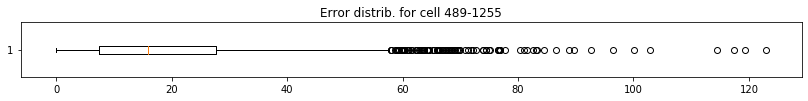

55


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


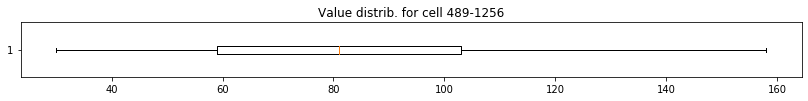

9008
Mean Absolute Error =  7.513673517635543


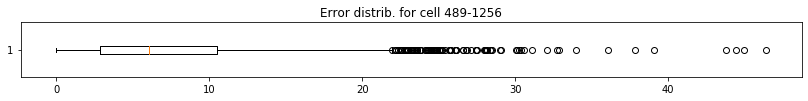

56


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


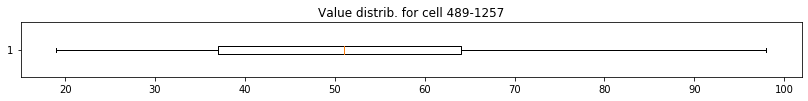

9008
Mean Absolute Error =  4.640698747591792


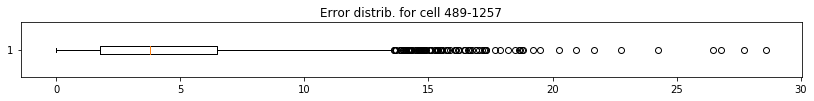

57


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


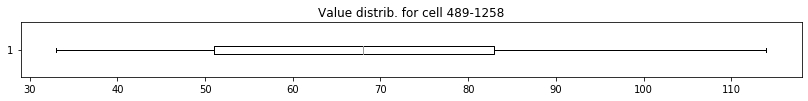

9008
Mean Absolute Error =  5.07274736639003


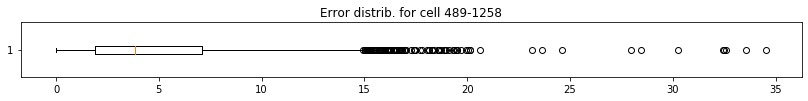

58


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


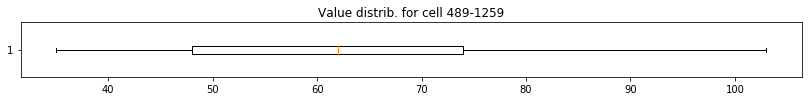

9008
Mean Absolute Error =  3.79173194597675


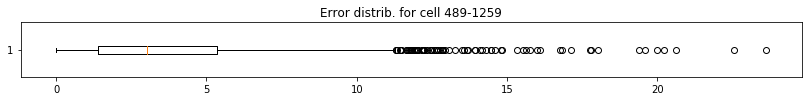

59


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


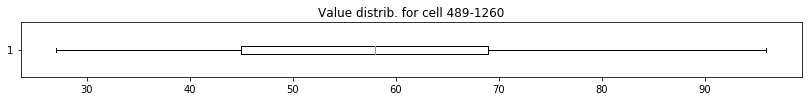

9008
Mean Absolute Error =  3.4189973791670427


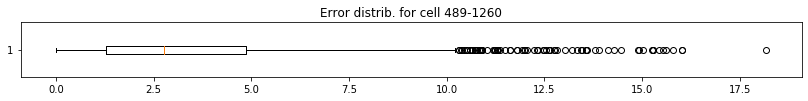

60


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


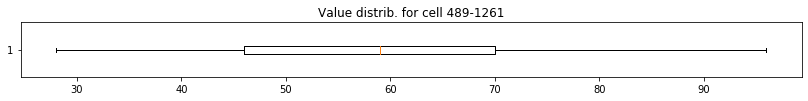

9008
Mean Absolute Error =  3.4030016326173453


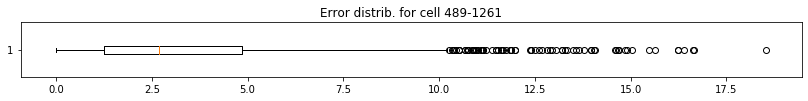

61


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


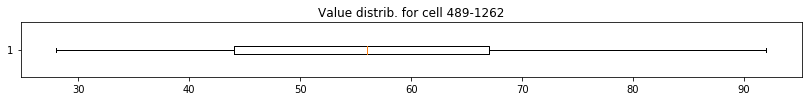

9008
Mean Absolute Error =  3.2403219267649845


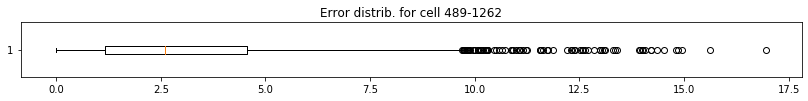

62


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


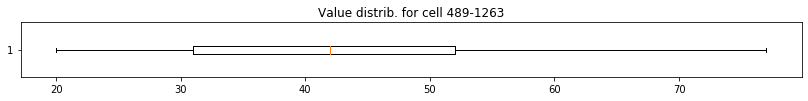

9008
Mean Absolute Error =  2.6542692997634547


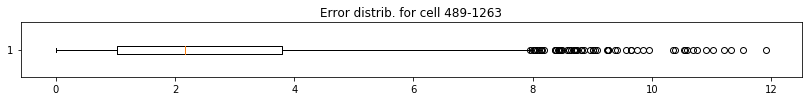

63


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


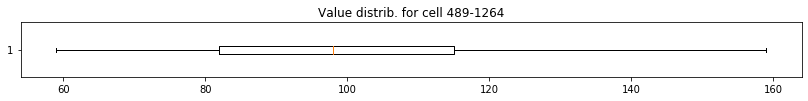

9008
Mean Absolute Error =  6.151401172221532


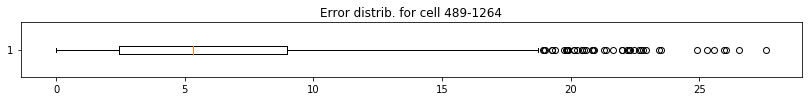

64


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


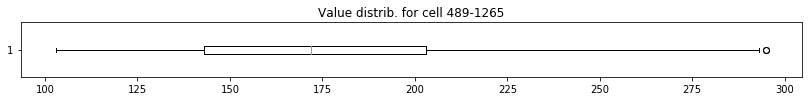

9008
Mean Absolute Error =  11.730700468238465


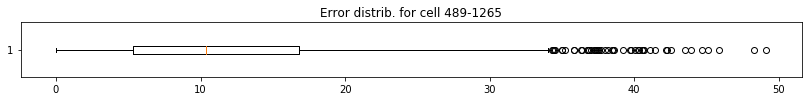

65


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


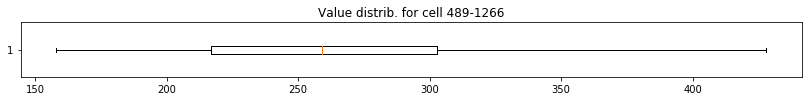

9008
Mean Absolute Error =  16.344964109206416


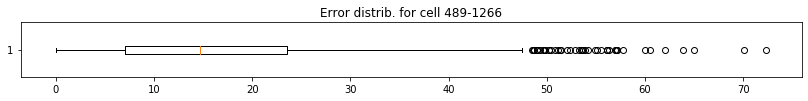

66


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


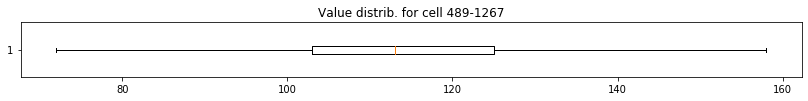

9008
Mean Absolute Error =  6.632671450775652


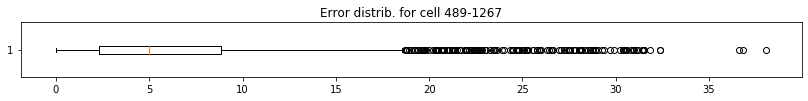

67


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


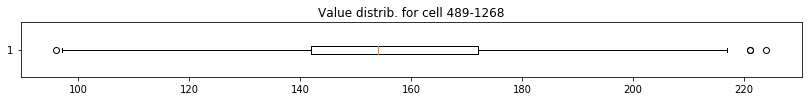

9008
Mean Absolute Error =  9.535031849452782


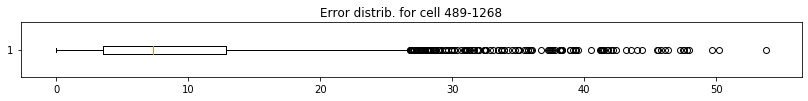

68


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


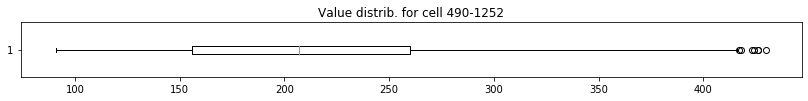

9008
Mean Absolute Error =  19.984114227331958


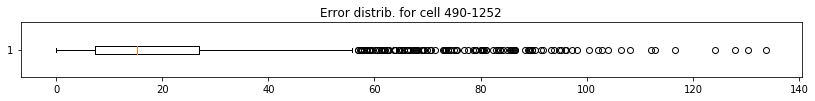

69


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


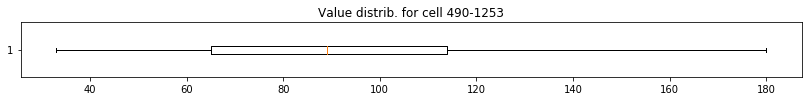

9008
Mean Absolute Error =  8.742922338128993


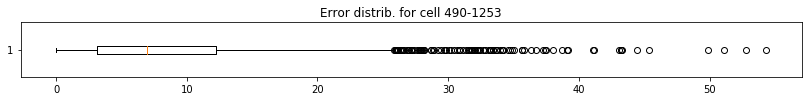

70


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


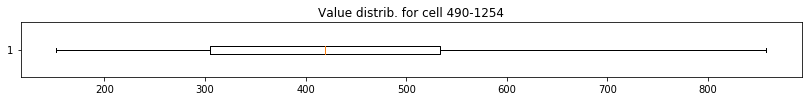

9008
Mean Absolute Error =  41.26502809373


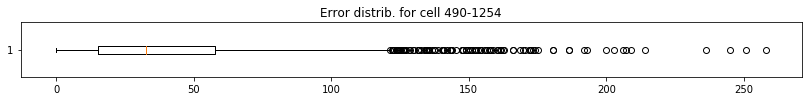

71


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


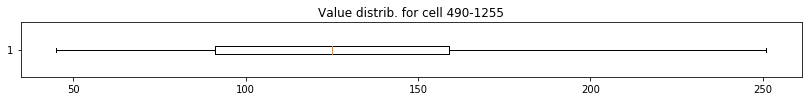

9008
Mean Absolute Error =  11.957863870595538


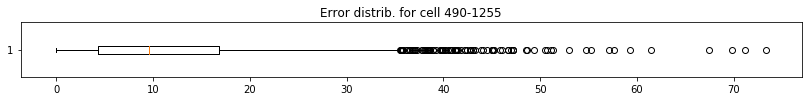

72


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


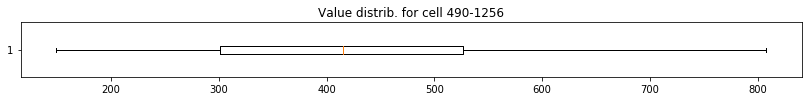

9008
Mean Absolute Error =  38.38388021106015


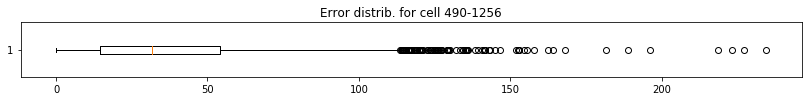

73


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


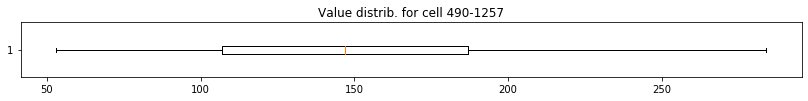

9008
Mean Absolute Error =  13.468918042491477


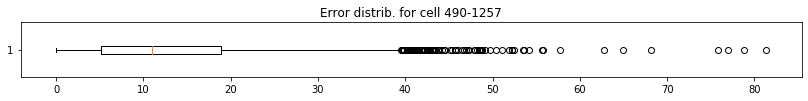

74


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


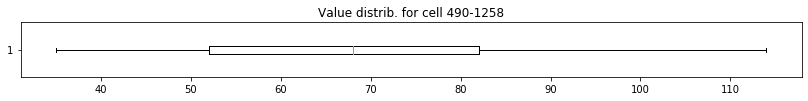

9008
Mean Absolute Error =  4.5147714275455995


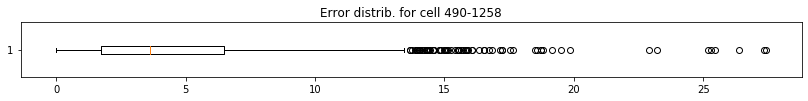

75


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


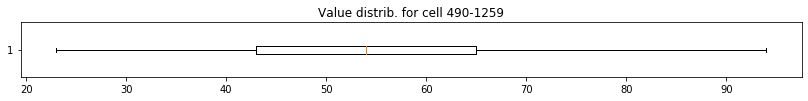

9008
Mean Absolute Error =  3.3797806733559863


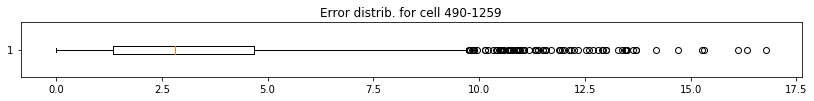

76


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


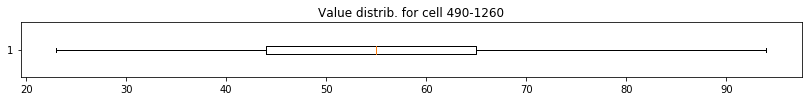

9008
Mean Absolute Error =  3.3864747998499944


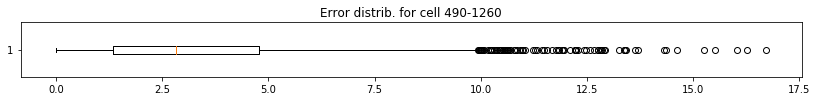

77


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


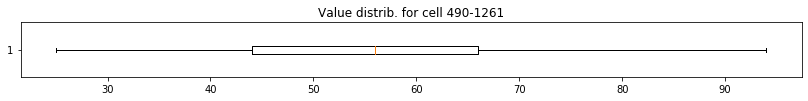

9008
Mean Absolute Error =  3.3883640814102947


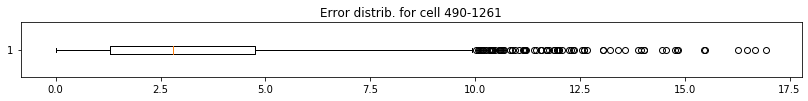

78


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


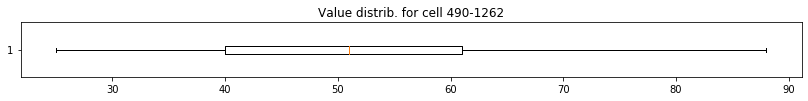

9008
Mean Absolute Error =  2.987581898235289


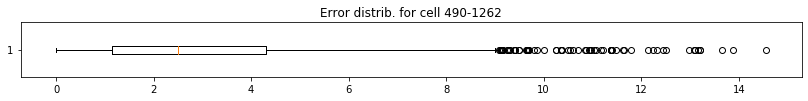

79


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


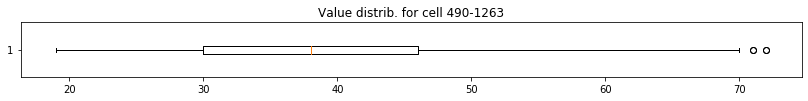

9008
Mean Absolute Error =  2.515171423297126


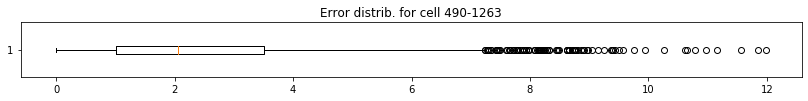

80


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


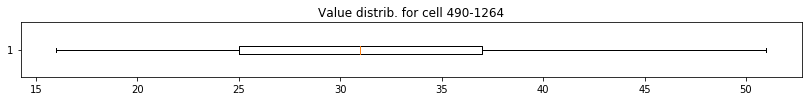

9008
Mean Absolute Error =  1.9776284095443266


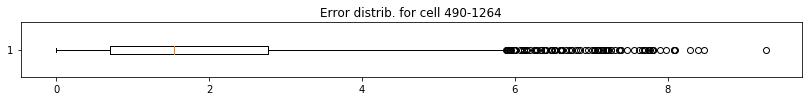

81


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


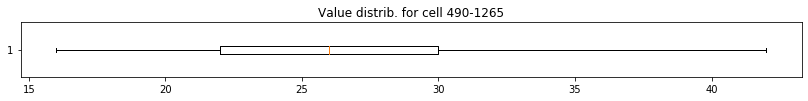

9008
Mean Absolute Error =  1.696144342230885


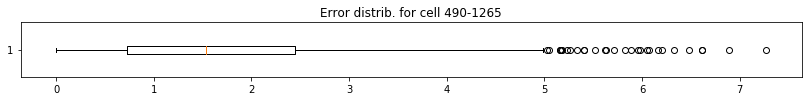

82


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


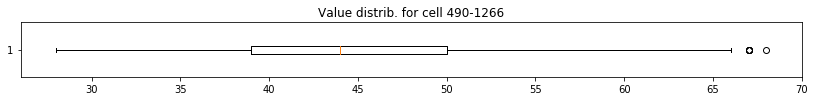

9008
Mean Absolute Error =  3.2277865250643574


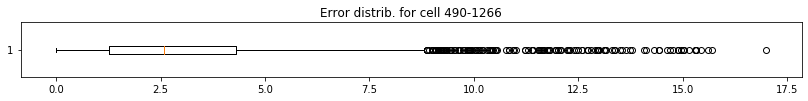

83


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


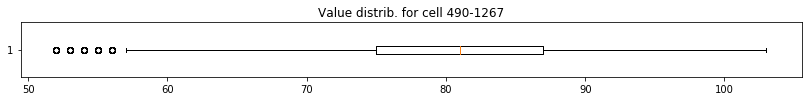

9008
Mean Absolute Error =  3.687575386089199


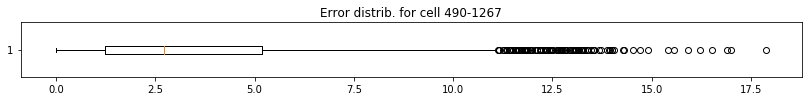

84


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


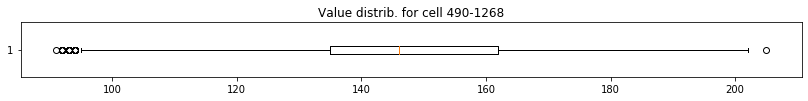

9008
Mean Absolute Error =  8.54300571148636


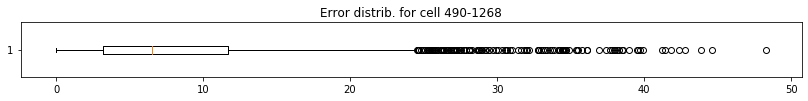

85


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


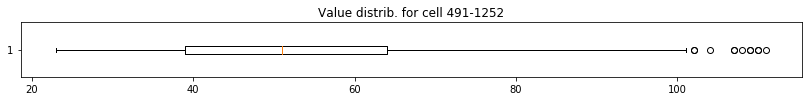

9008
Mean Absolute Error =  5.08862508777856


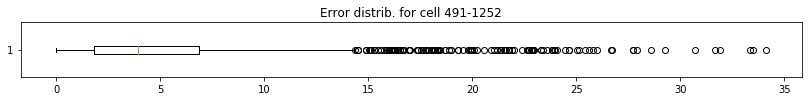

86


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


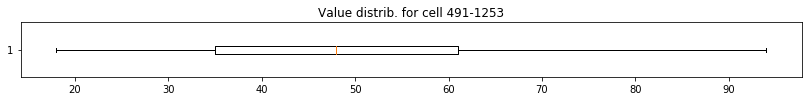

9008
Mean Absolute Error =  4.544181234055388


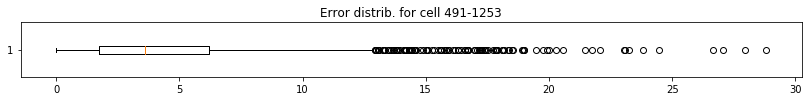

87


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


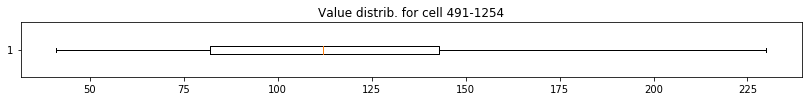

9008
Mean Absolute Error =  11.091968433608134


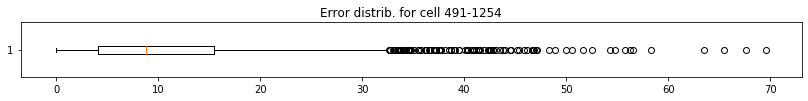

88


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


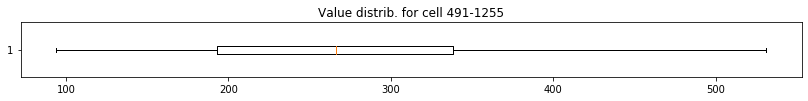

9008
Mean Absolute Error =  25.239852510729698


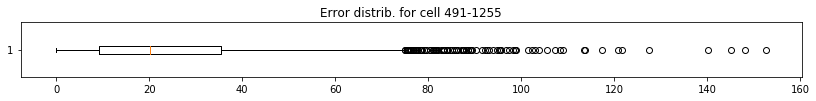

89


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


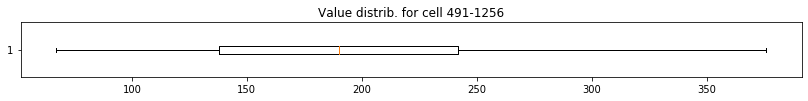

9008
Mean Absolute Error =  17.806090399025525


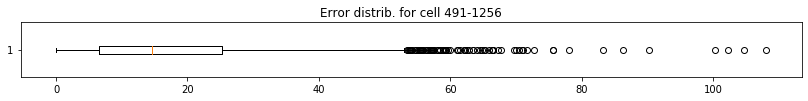

90


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


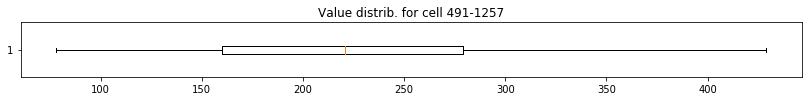

9008
Mean Absolute Error =  20.045567638398133


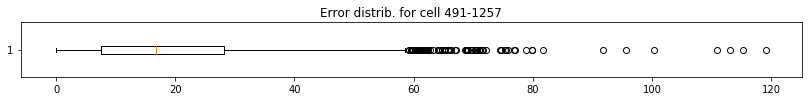

91


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


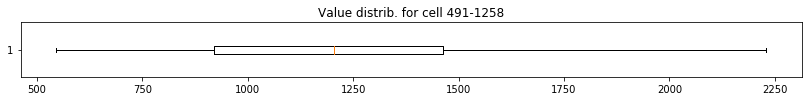

9008
Mean Absolute Error =  82.33725701402969


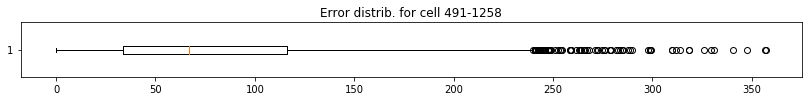

92


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


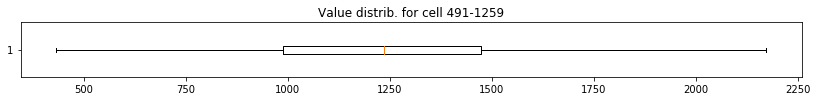

9008
Mean Absolute Error =  82.07648481233551


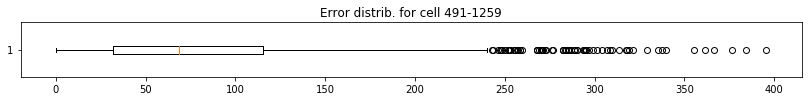

93


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


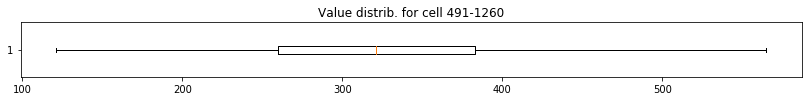

9008
Mean Absolute Error =  21.125389293088983


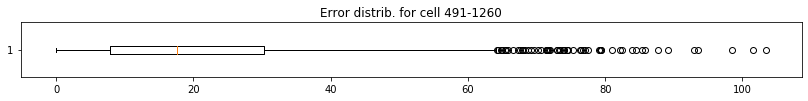

94


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


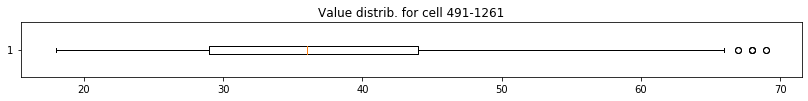

9008
Mean Absolute Error =  2.7796506971322543


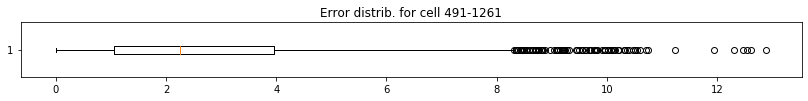

95


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


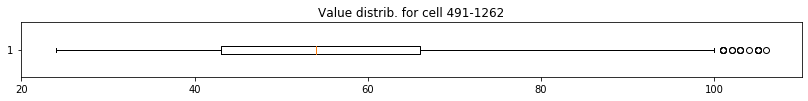

9008
Mean Absolute Error =  4.473666147258883


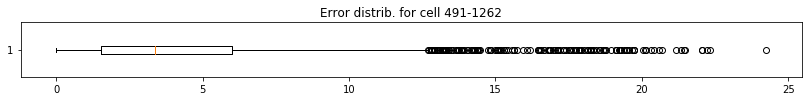

96


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


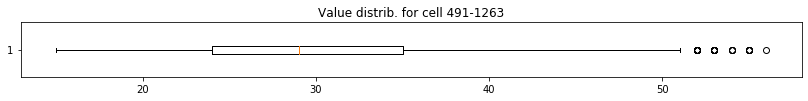

9008
Mean Absolute Error =  1.9285902235798227


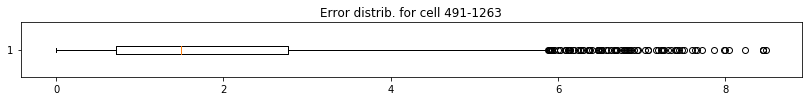

97


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


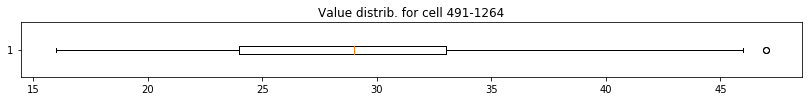

9008
Mean Absolute Error =  1.667444317270517


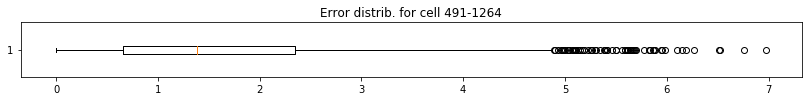

98


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


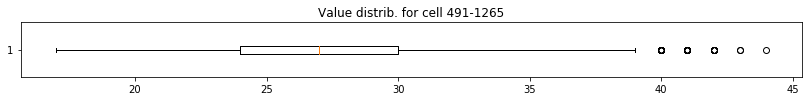

9008
Mean Absolute Error =  1.8669963147365791


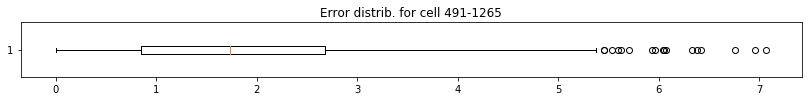

99


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


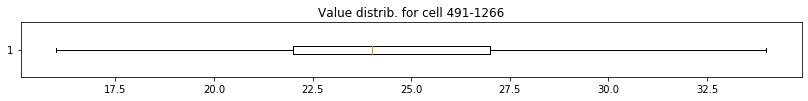

9008
Mean Absolute Error =  1.337265684978136


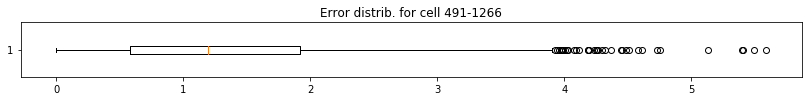

100


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


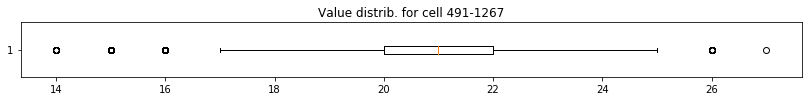

9008
Mean Absolute Error =  0.8047954763419775


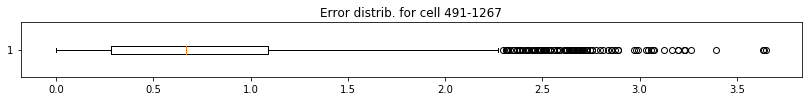

101


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


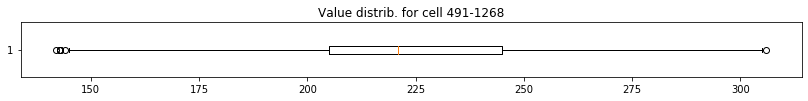

9008
Mean Absolute Error =  13.448397945863347


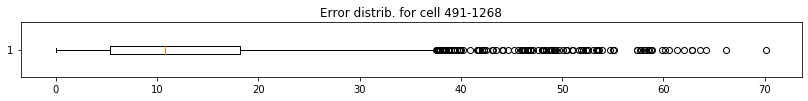

102


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


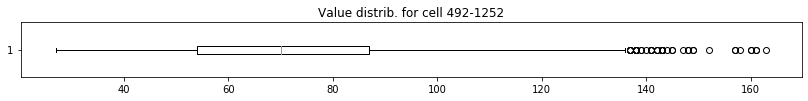

9008
Mean Absolute Error =  7.607713465059634


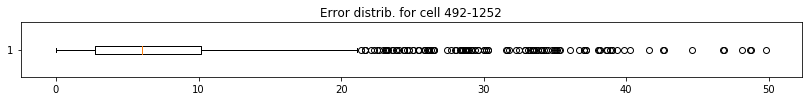

103


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


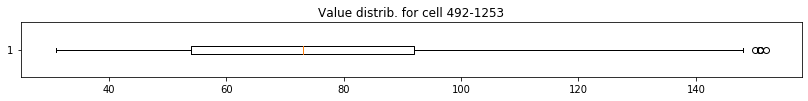

9008
Mean Absolute Error =  7.218483503260512


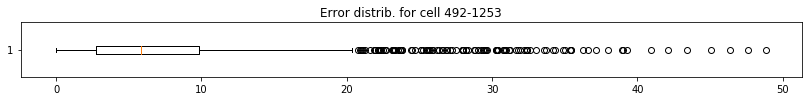

104


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


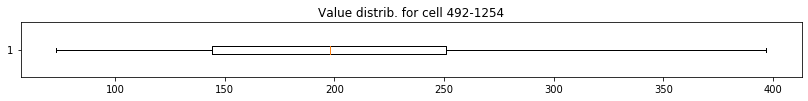

9008
Mean Absolute Error =  18.9613963532639


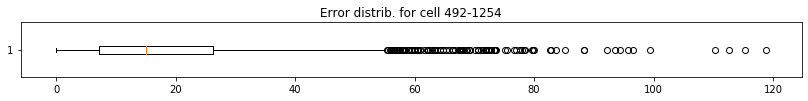

105


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


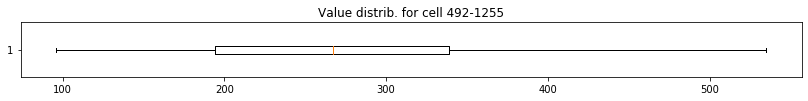

9008
Mean Absolute Error =  25.496053695313094


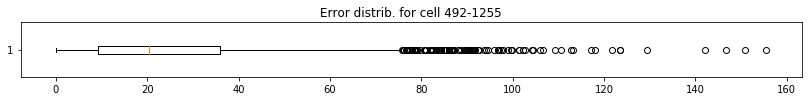

106


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


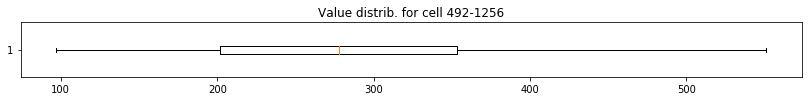

9008
Mean Absolute Error =  26.05268127201905


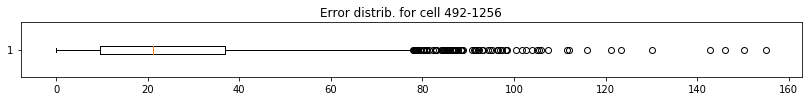

107


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


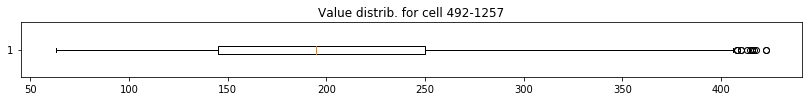

9008
Mean Absolute Error =  17.870187816145414


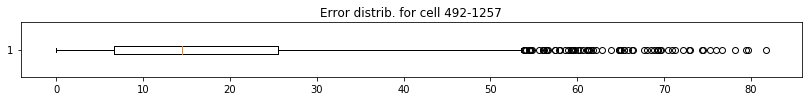

108


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


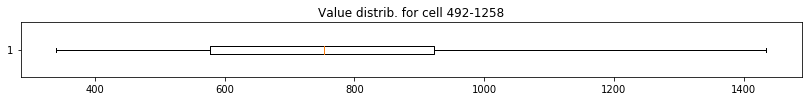

9008
Mean Absolute Error =  55.17590545745977


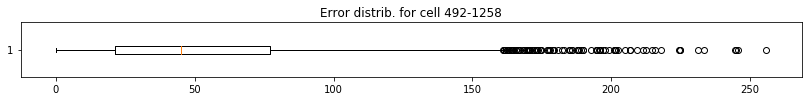

109


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


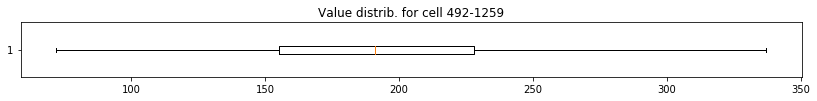

9008
Mean Absolute Error =  12.28955478261944


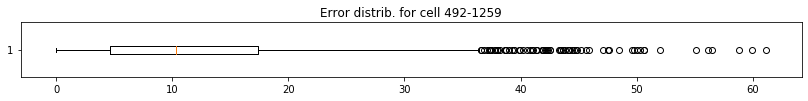

110


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


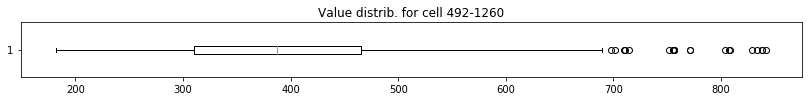

9008
Mean Absolute Error =  23.576228057597245


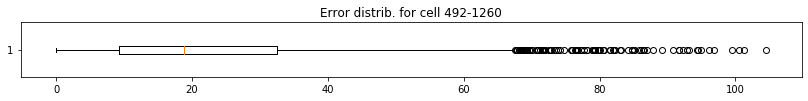

111


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


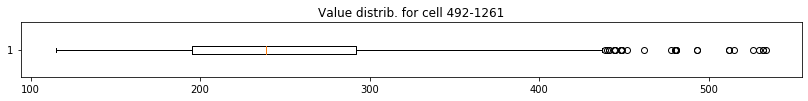

9008
Mean Absolute Error =  18.99003608057377


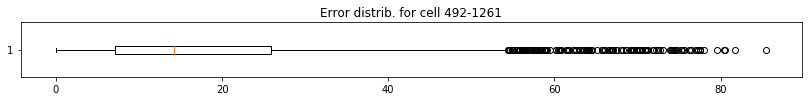

112


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


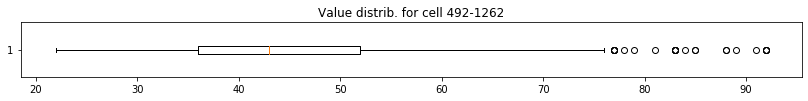

9008
Mean Absolute Error =  3.131615593427407


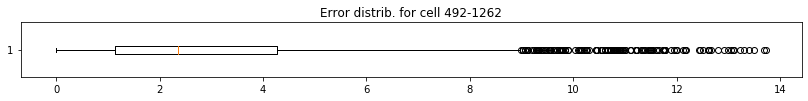

113


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


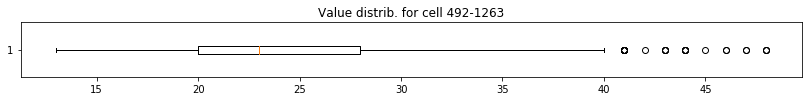

9008
Mean Absolute Error =  1.6420999619012946


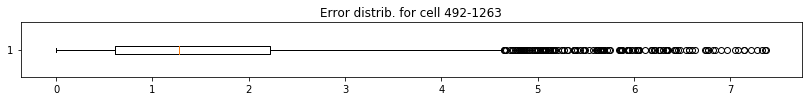

114


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


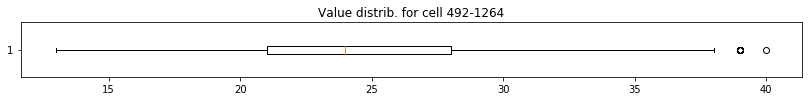

9008
Mean Absolute Error =  1.5463601797203221


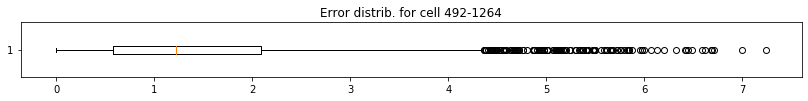

115


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


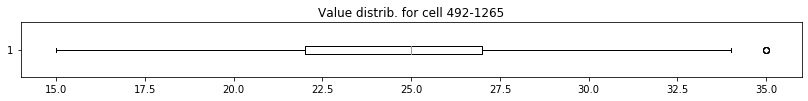

9008
Mean Absolute Error =  1.5241112539684818


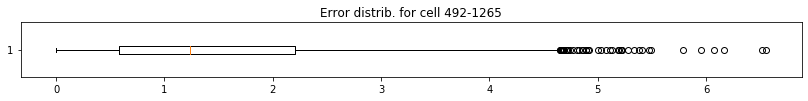

116


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


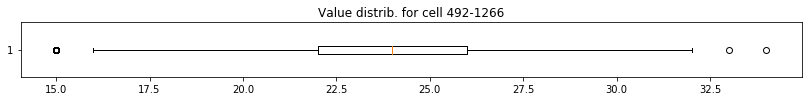

9008
Mean Absolute Error =  1.738002834278318


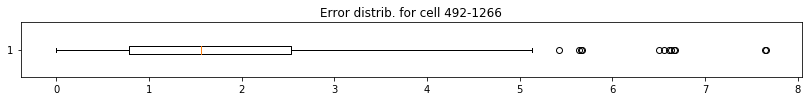

117


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


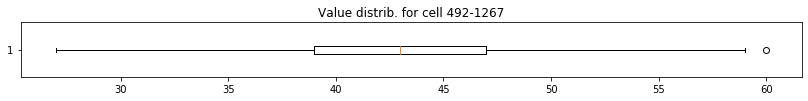

9008
Mean Absolute Error =  2.2959488638320784


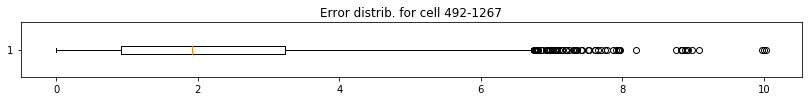

118


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


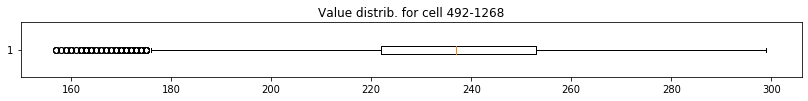

9008
Mean Absolute Error =  9.417306636139376


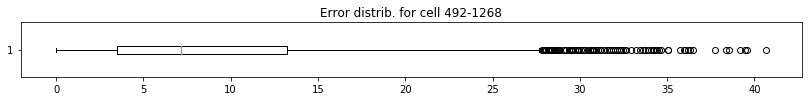

119


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


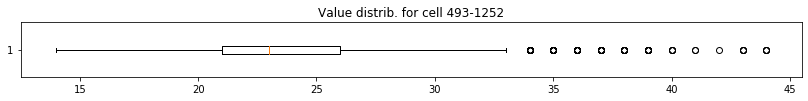

9008
Mean Absolute Error =  1.6819300497818939


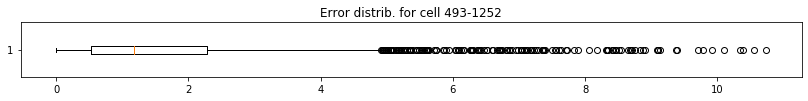

120


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


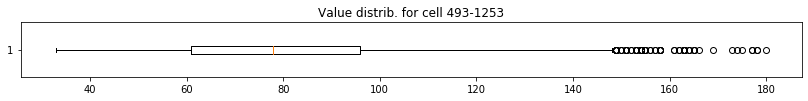

9008
Mean Absolute Error =  8.88036399581348


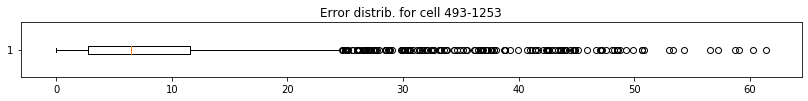

121


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


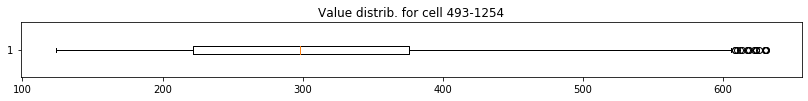

9008
Mean Absolute Error =  31.84770563853941


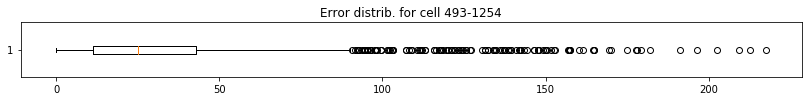

122


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


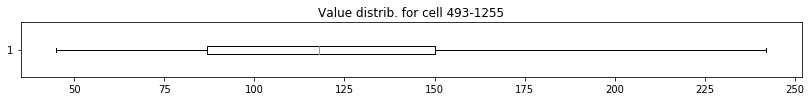

9008
Mean Absolute Error =  11.674283291029752


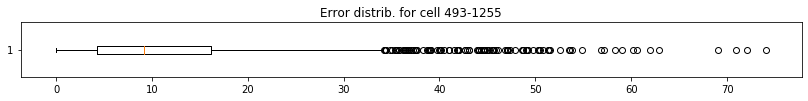

123


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


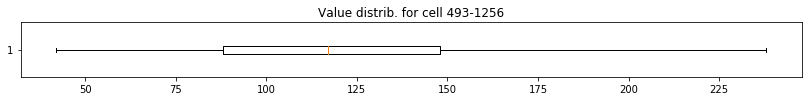

9008
Mean Absolute Error =  9.752076366691549


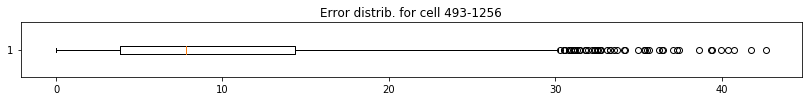

124


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


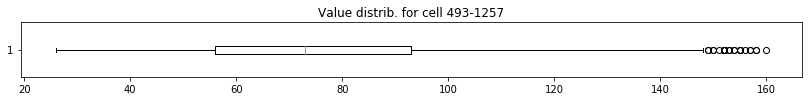

9008
Mean Absolute Error =  7.554615884123959


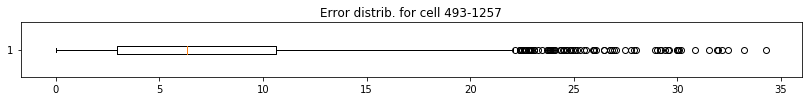

125


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


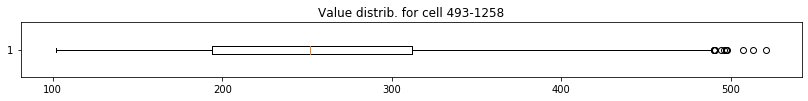

9008
Mean Absolute Error =  23.19016626715762


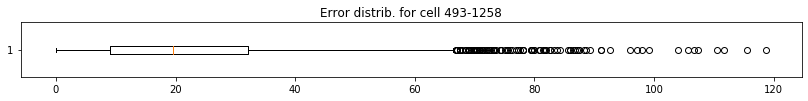

126


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


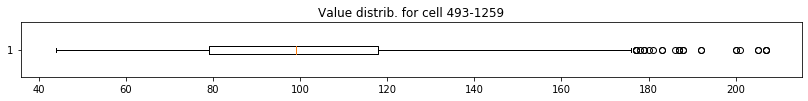

9008
Mean Absolute Error =  7.3338076534973515


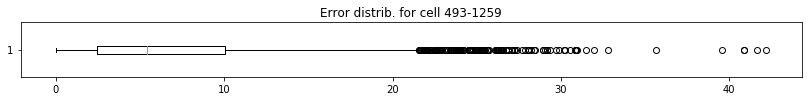

127


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


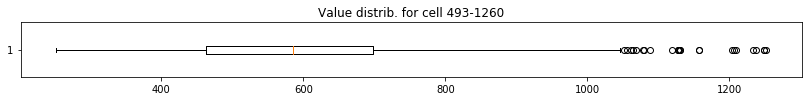

9008
Mean Absolute Error =  39.7218988639562


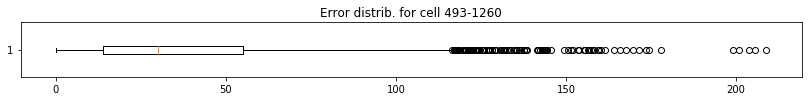

128


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


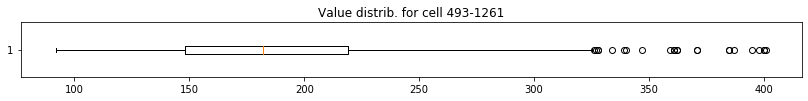

9008
Mean Absolute Error =  12.173103887342974


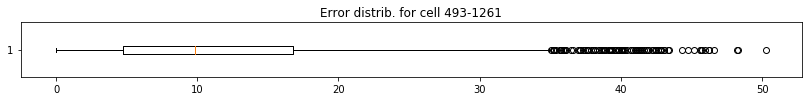

129


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


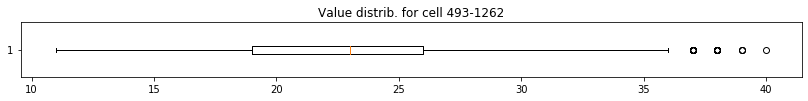

9008
Mean Absolute Error =  1.572381807834929


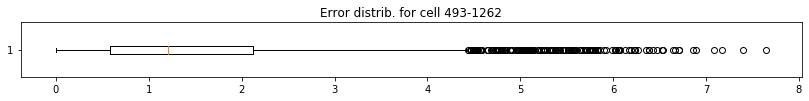

130


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


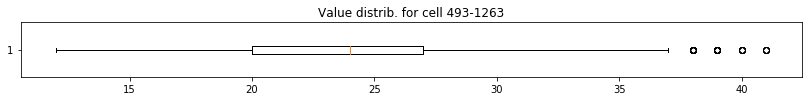

9008
Mean Absolute Error =  1.5841168202096072


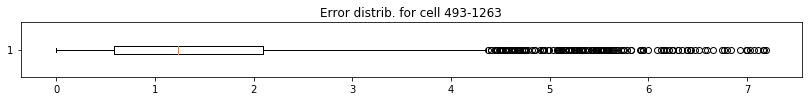

131


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


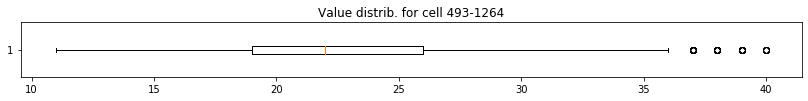

9008
Mean Absolute Error =  1.5874386313246065


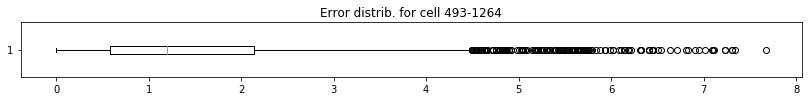

132


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


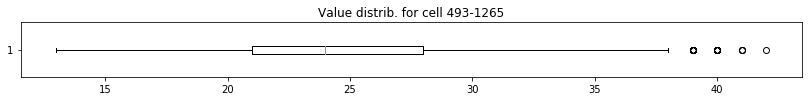

9008
Mean Absolute Error =  1.5542160632234474


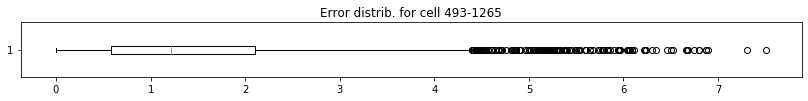

133


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


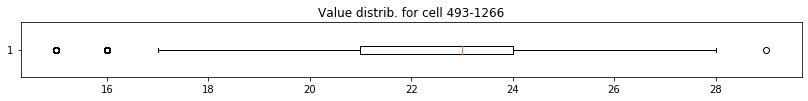

9008
Mean Absolute Error =  1.1631263951530024


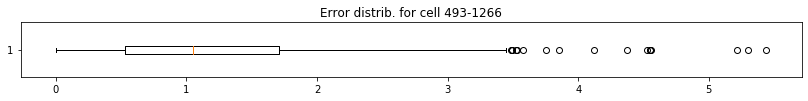

134


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


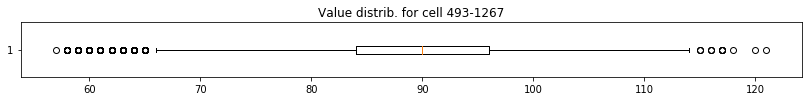

9008
Mean Absolute Error =  5.845835867330708


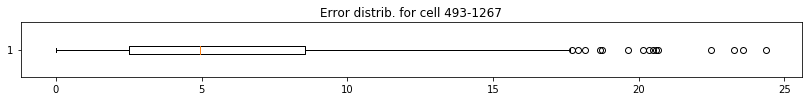

135


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


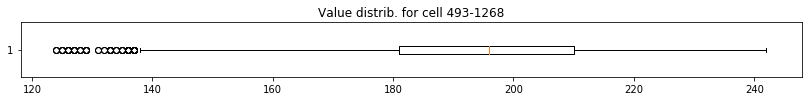

9008
Mean Absolute Error =  6.568140108036967


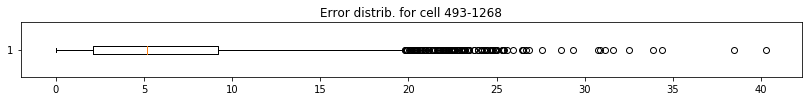

136


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


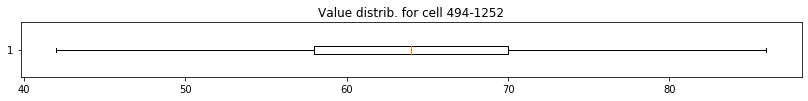

9008
Mean Absolute Error =  2.4263823050677717


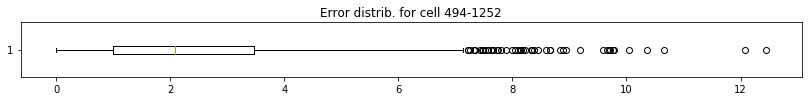

137


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


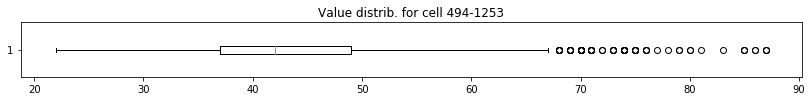

9008
Mean Absolute Error =  3.671371913529738


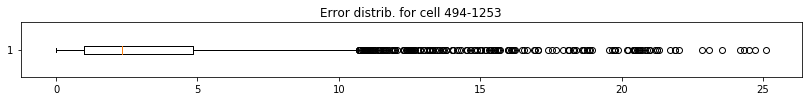

138


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


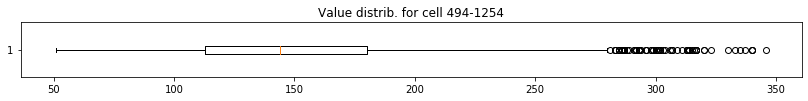

9008
Mean Absolute Error =  18.015783610654218


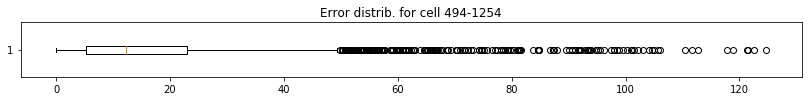

139


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


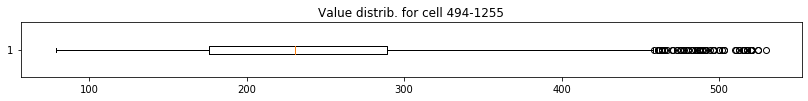

9008
Mean Absolute Error =  29.245313695412218


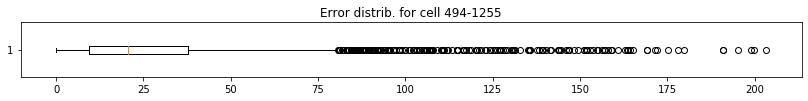

140


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


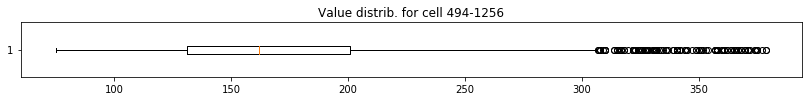

9008
Mean Absolute Error =  23.246652644426437


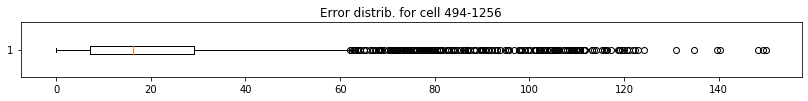

141


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


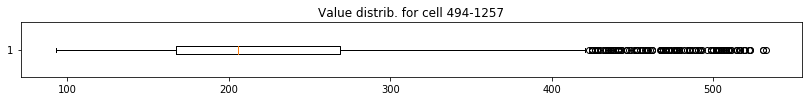

9008
Mean Absolute Error =  34.81809263484922


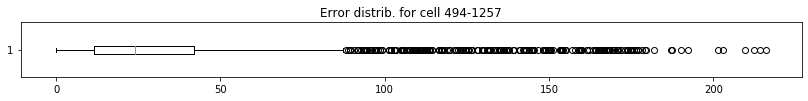

142


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


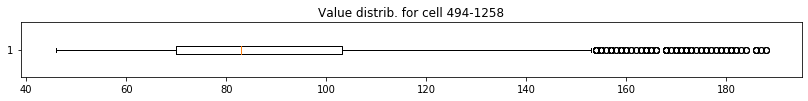

9008
Mean Absolute Error =  12.521175043512438


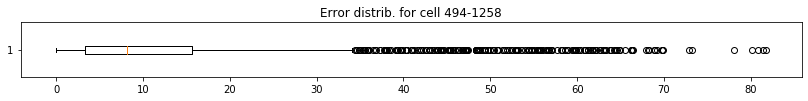

143


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


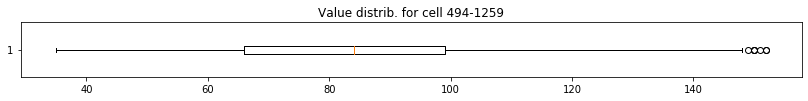

9008
Mean Absolute Error =  6.4200094262116805


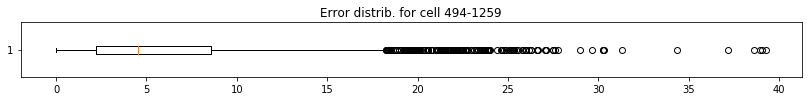

144


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


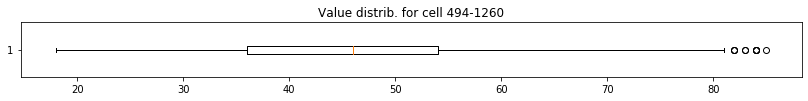

9008
Mean Absolute Error =  3.329719282018619


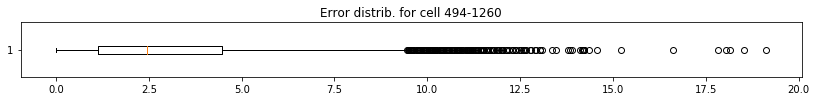

145


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


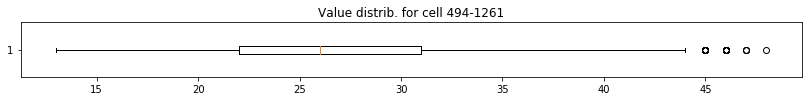

9008
Mean Absolute Error =  1.4884267676649408


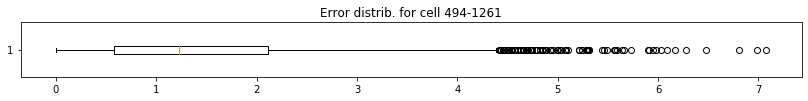

146


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


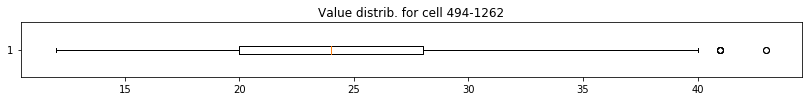

9008
Mean Absolute Error =  1.4405509276267567


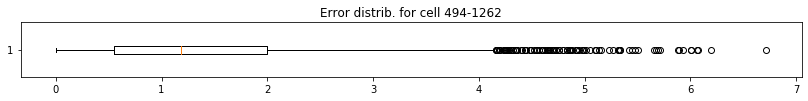

147


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


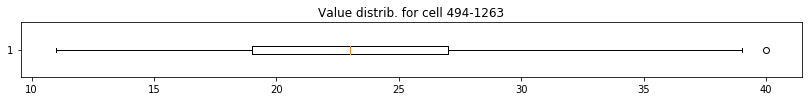

9008
Mean Absolute Error =  1.4442447707655266


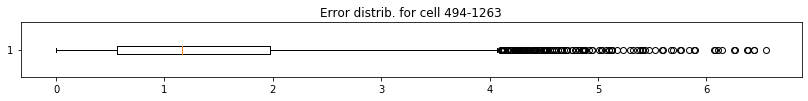

148


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


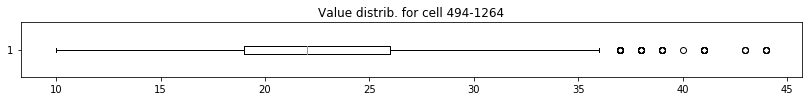

9008
Mean Absolute Error =  1.3248986830366405


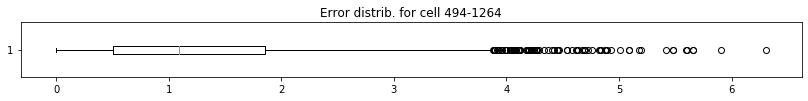

149


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


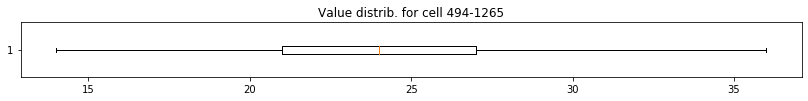

9008
Mean Absolute Error =  1.3195190291913712


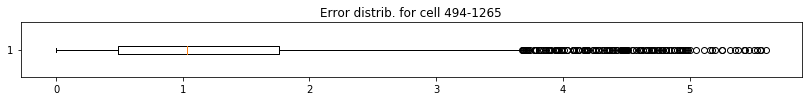

150


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


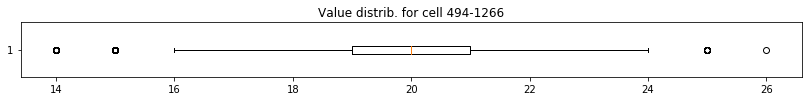

9008
Mean Absolute Error =  0.6841780380445177


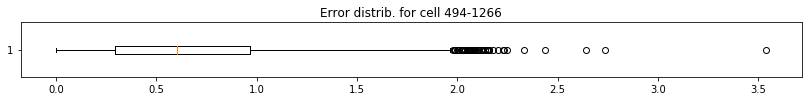

151


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


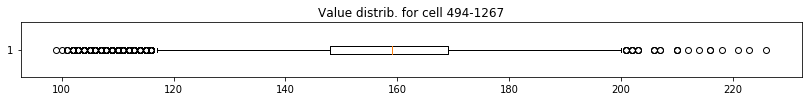

9008
Mean Absolute Error =  10.334891991005327


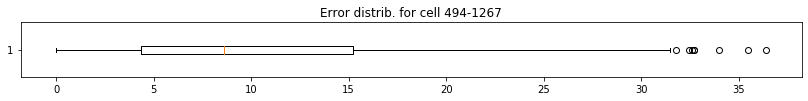

152


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


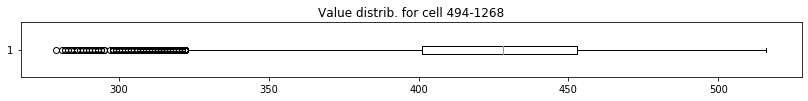

9008
Mean Absolute Error =  16.80109358371853


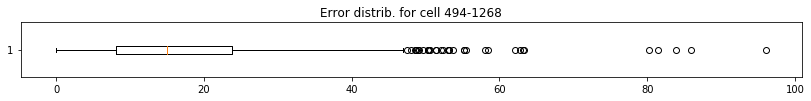

153


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


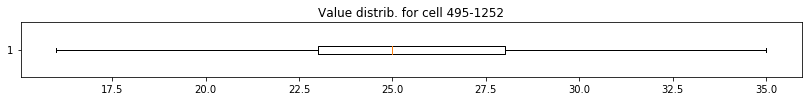

9008
Mean Absolute Error =  0.9572576431391113


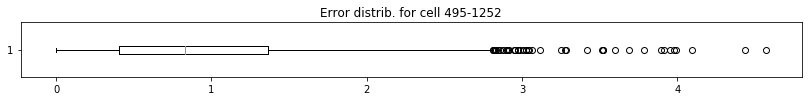

154


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


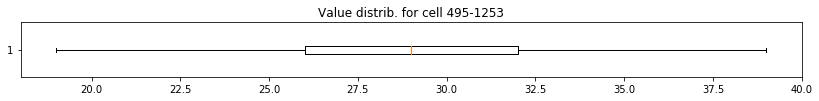

9008
Mean Absolute Error =  1.065333081954156


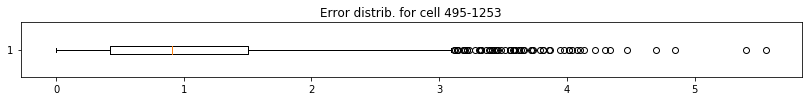

155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


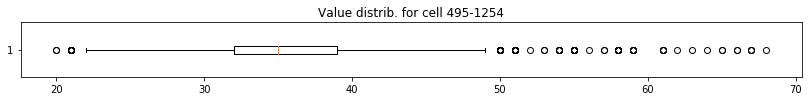

9008
Mean Absolute Error =  2.412982260356486


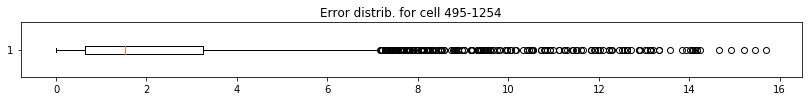

156


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


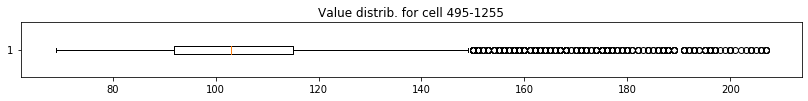

9008
Mean Absolute Error =  13.100926626420975


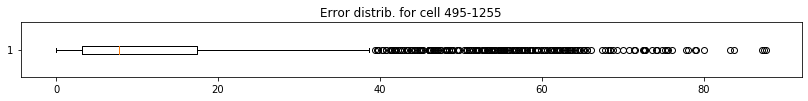

157


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


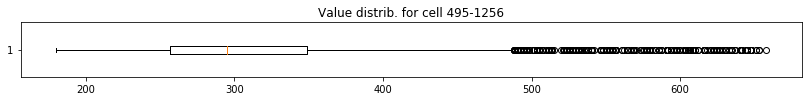

9008
Mean Absolute Error =  44.9577651905478


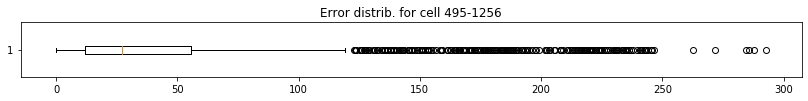

158


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


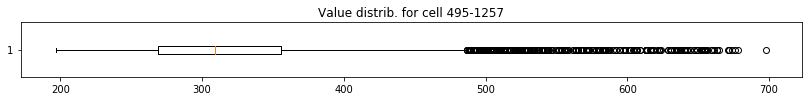

9008
Mean Absolute Error =  48.2082308812692


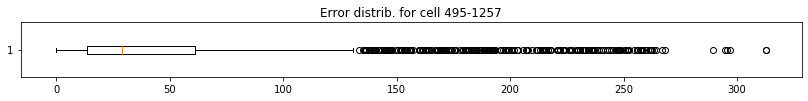

159


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


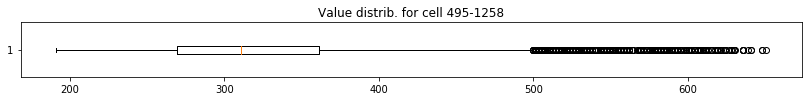

9008
Mean Absolute Error =  46.600479970998606


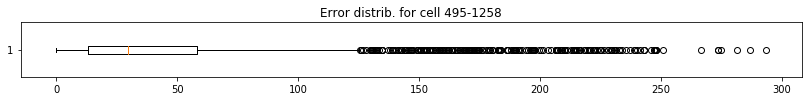

160


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


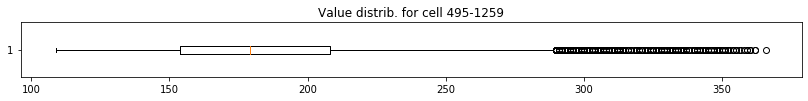

9008
Mean Absolute Error =  25.074632565799632


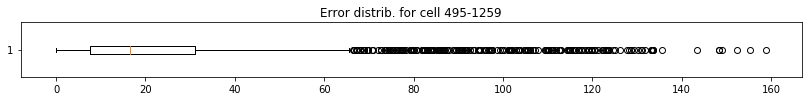

161


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


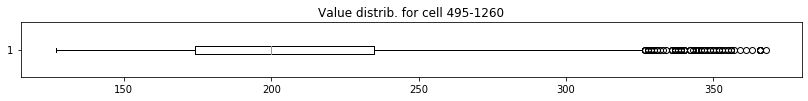

9008
Mean Absolute Error =  11.11719373484099


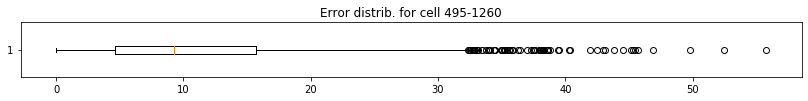

162


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


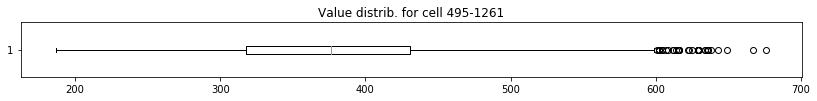

9008
Mean Absolute Error =  19.492132051558162


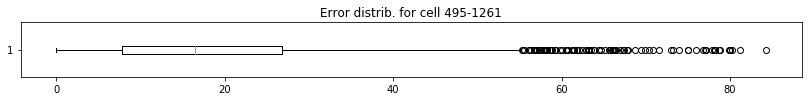

163


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


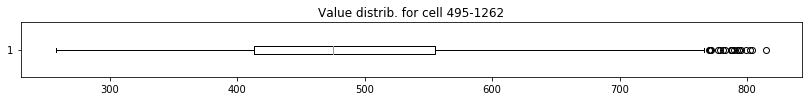

9008
Mean Absolute Error =  30.687432202506322


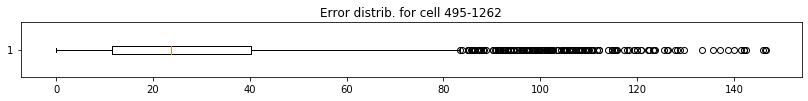

164


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


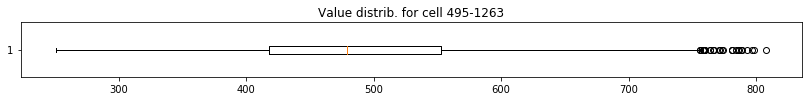

9008
Mean Absolute Error =  30.121536624922992


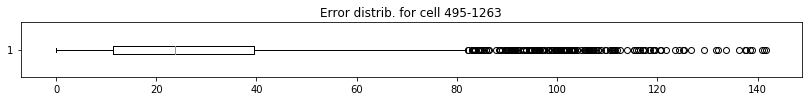

165


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


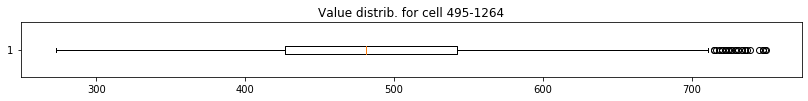

9008
Mean Absolute Error =  28.434564049623056


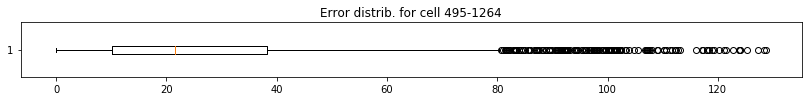

166


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


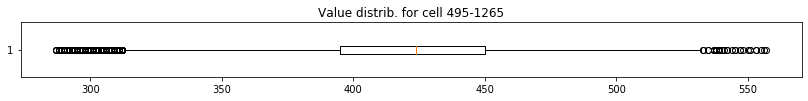

9008
Mean Absolute Error =  15.081532123976737


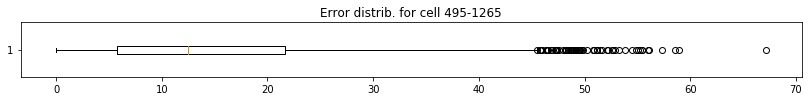

167


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


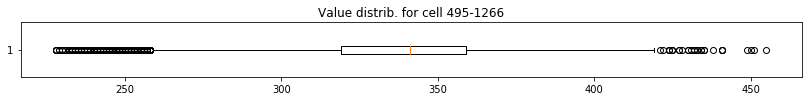

9008
Mean Absolute Error =  14.567710592992968


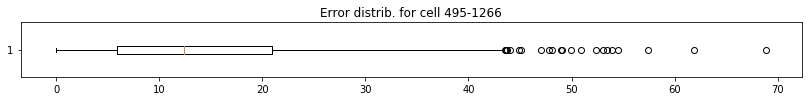

168


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


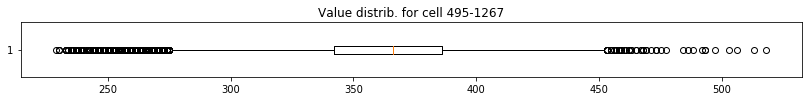

9008
Mean Absolute Error =  22.164430318331302


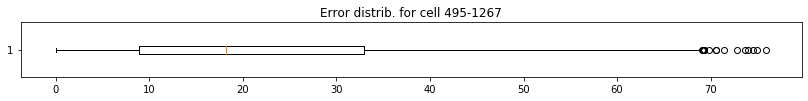

169


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


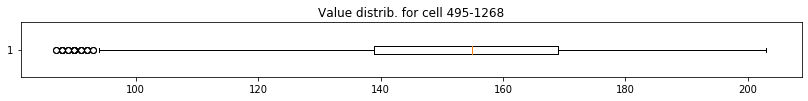

9008
Mean Absolute Error =  5.569362814750239


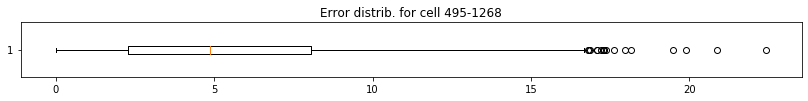

170


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


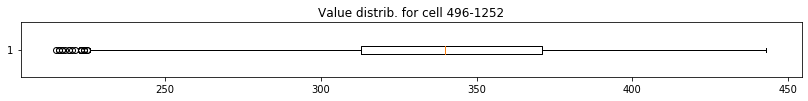

9008
Mean Absolute Error =  11.709311386259392


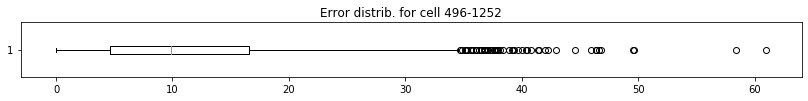

171


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


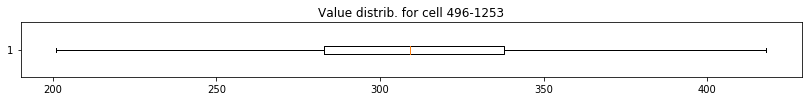

9008
Mean Absolute Error =  11.03585965977134


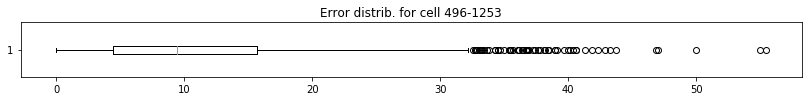

172


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


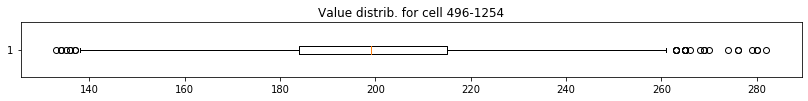

9008
Mean Absolute Error =  7.231285623213165


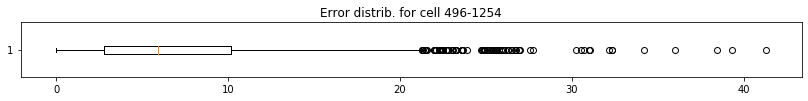

173


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


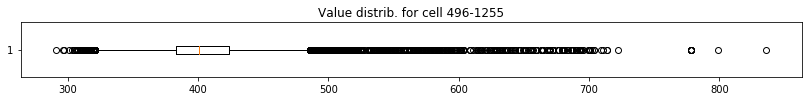

9008
Mean Absolute Error =  52.45501625667426


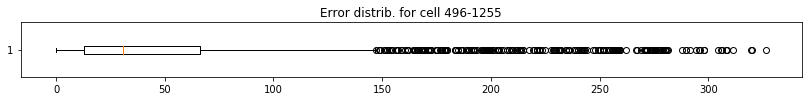

174


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


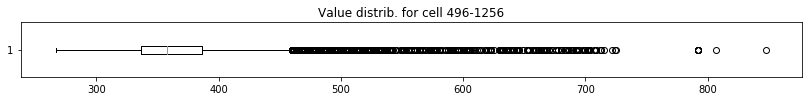

9008
Mean Absolute Error =  56.38300778111052


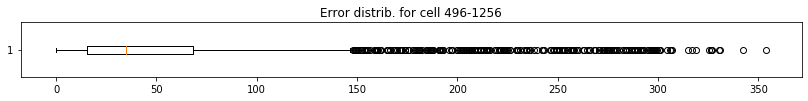

175


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


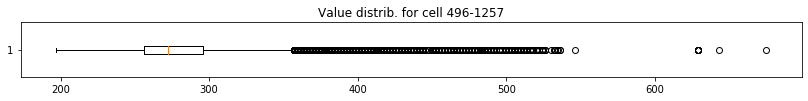

9008
Mean Absolute Error =  44.29355301761306


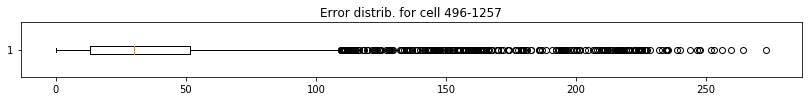

176


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


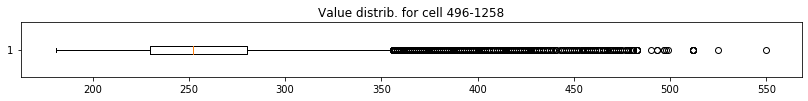

9008
Mean Absolute Error =  35.92889096988692


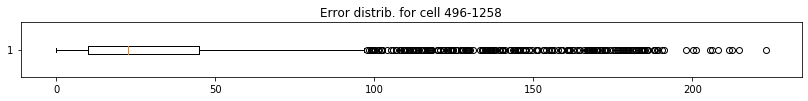

177


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


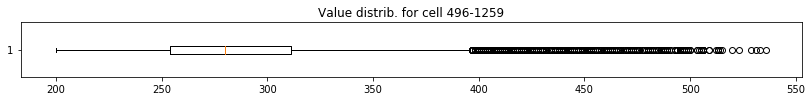

9008
Mean Absolute Error =  34.69951128609469


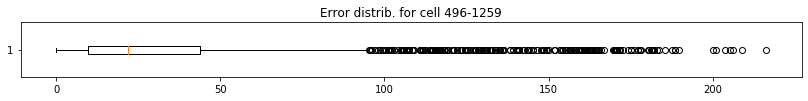

178


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


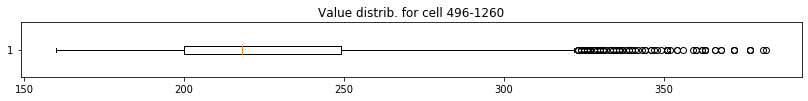

9008
Mean Absolute Error =  12.653945720051981


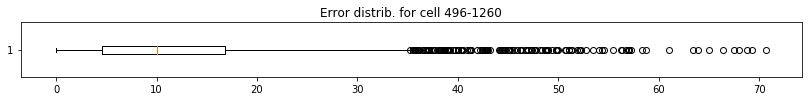

179


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


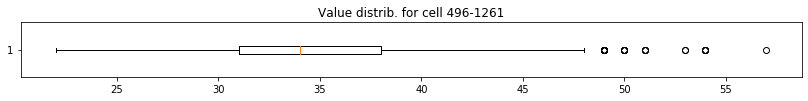

9008
Mean Absolute Error =  2.612895958745813


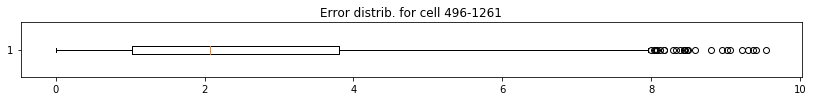

180


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


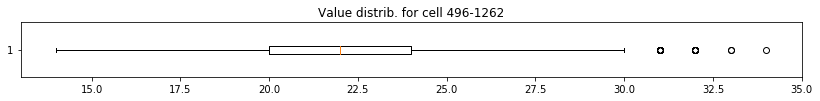

9008
Mean Absolute Error =  1.3857638640942833


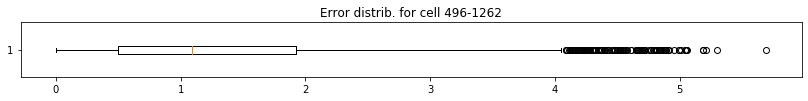

181


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


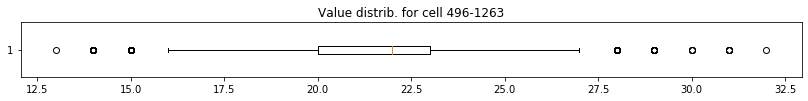

9008
Mean Absolute Error =  1.3034157083681384


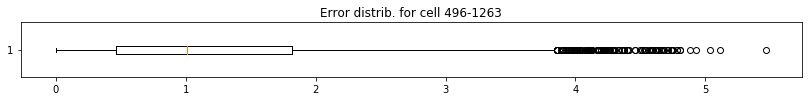

182


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


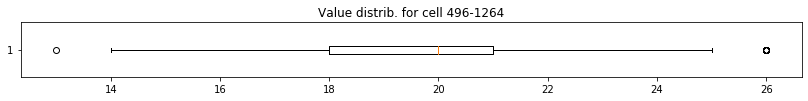

9008
Mean Absolute Error =  0.8282533925712456


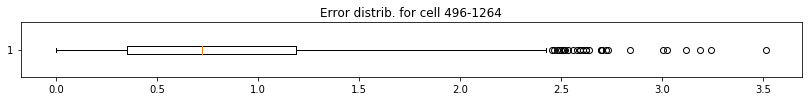

183


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


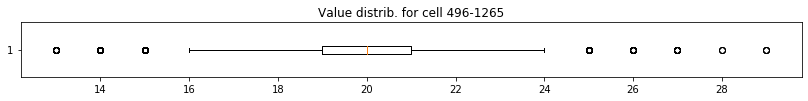

9008
Mean Absolute Error =  1.2154029165946814


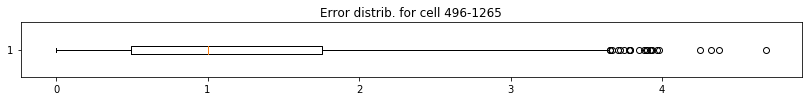

184


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


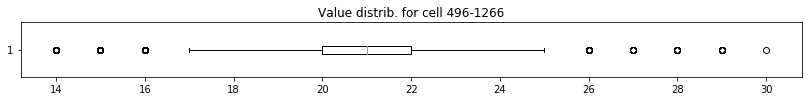

9008
Mean Absolute Error =  1.031546191434067


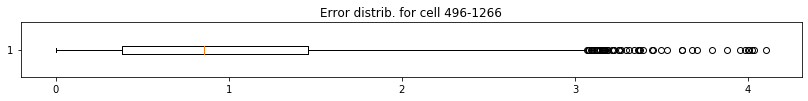

185


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


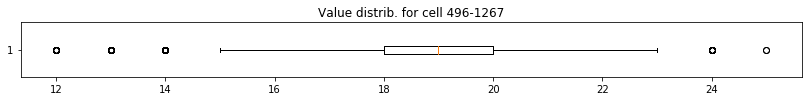

9008
Mean Absolute Error =  0.6654998963628513


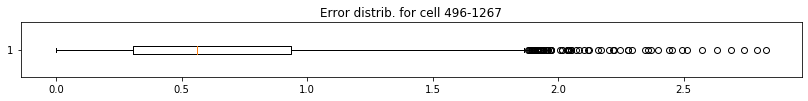

186


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


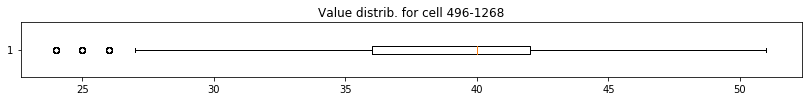

9008
Mean Absolute Error =  1.371729843262544


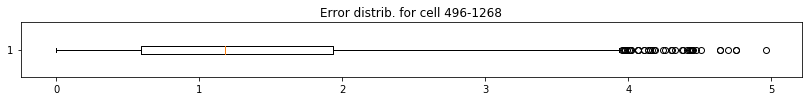

187


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


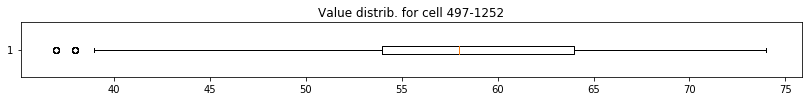

9008
Mean Absolute Error =  1.9864495760566778


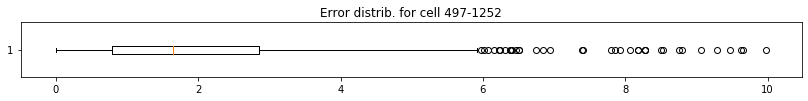

188


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


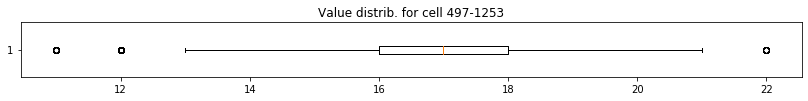

9008
Mean Absolute Error =  0.6530297234927912


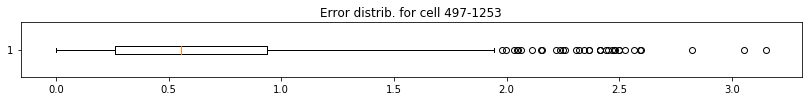

189


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


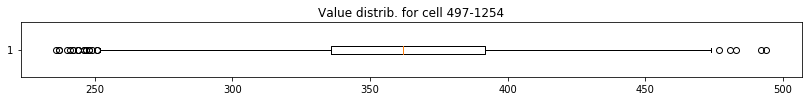

9008
Mean Absolute Error =  11.914315526635473


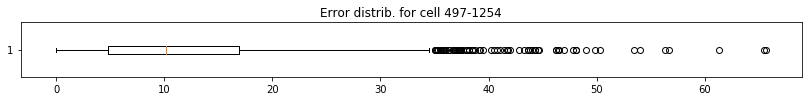

190


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


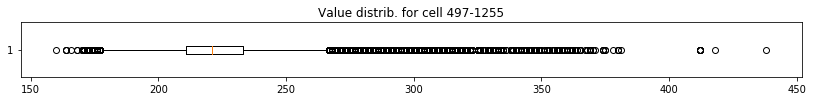

9008
Mean Absolute Error =  26.66953056150232


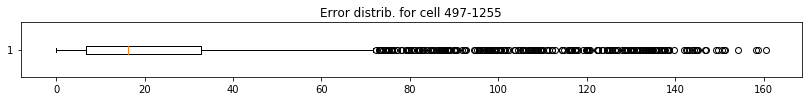

191


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


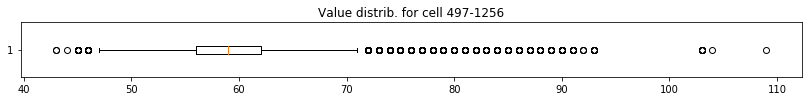

9008
Mean Absolute Error =  6.1663022062974155


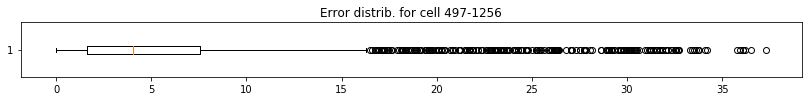

192


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


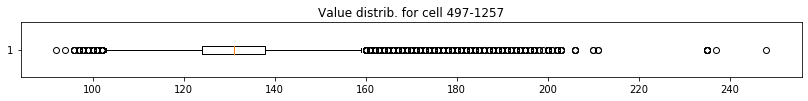

9008
Mean Absolute Error =  13.877651528022689


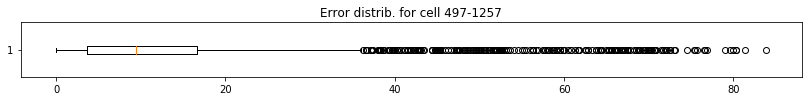

193


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


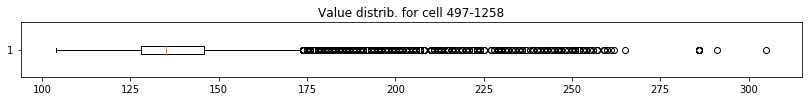

9008
Mean Absolute Error =  20.17846718350153


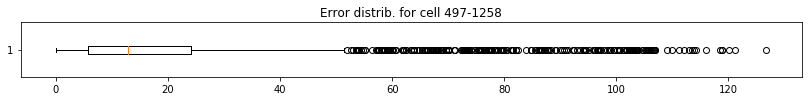

194


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


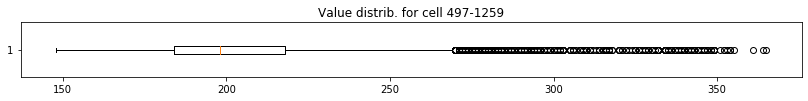

9008
Mean Absolute Error =  23.899336300417133


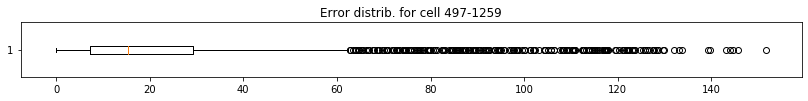

195


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


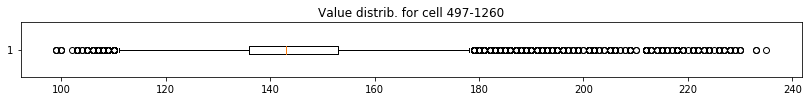

9008
Mean Absolute Error =  14.337820198781785


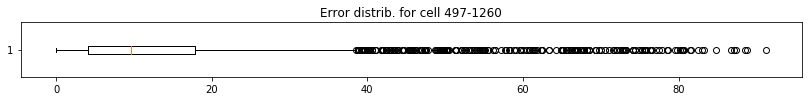

196


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


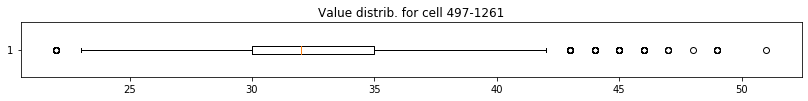

9008
Mean Absolute Error =  2.2994304510903674


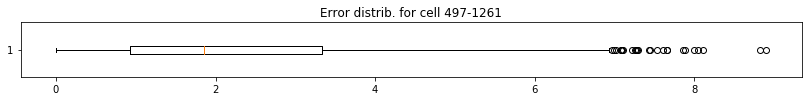

197


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


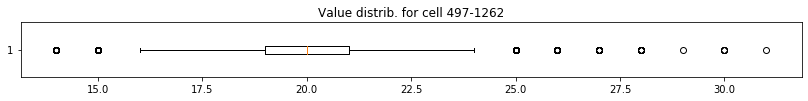

9008
Mean Absolute Error =  1.317437438253816


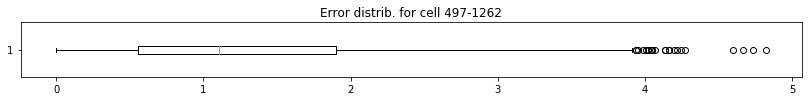

198


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


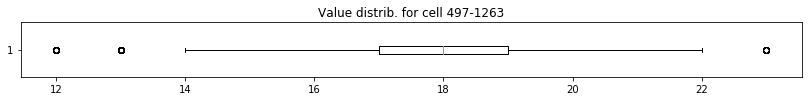

9008
Mean Absolute Error =  0.5944863213480478


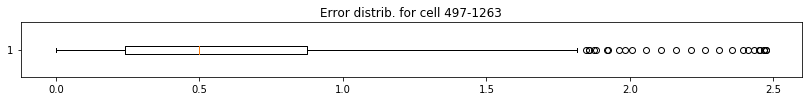

199


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


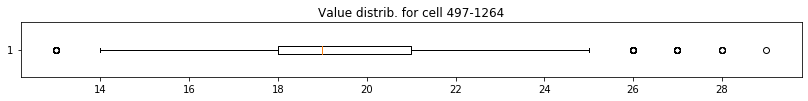

9008
Mean Absolute Error =  1.1544080478907353


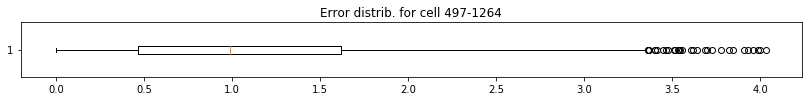

200


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


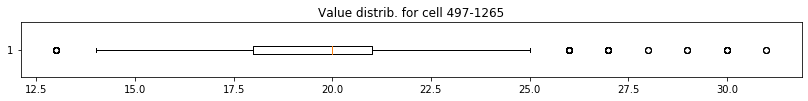

9008
Mean Absolute Error =  1.251216965459002


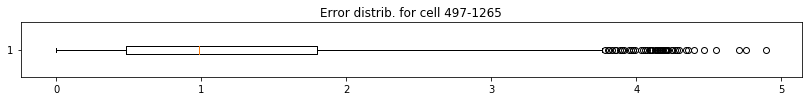

201


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


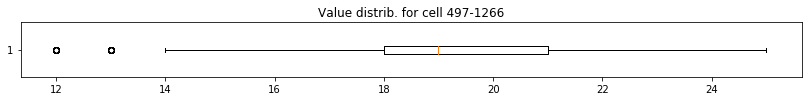

9008
Mean Absolute Error =  0.7283711355092383


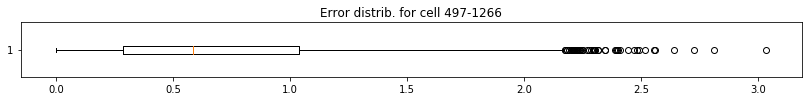

202


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


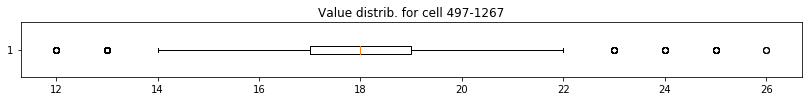

9008
Mean Absolute Error =  0.6940277552864211


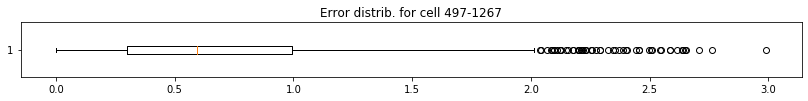

203


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


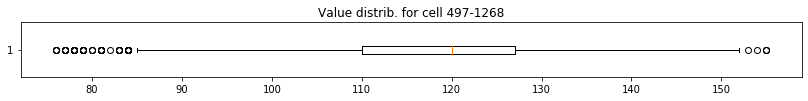

9008
Mean Absolute Error =  4.451235466733807


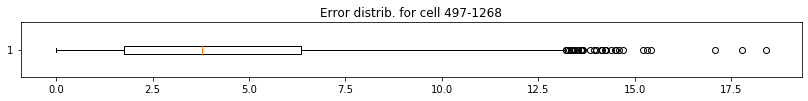

204


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


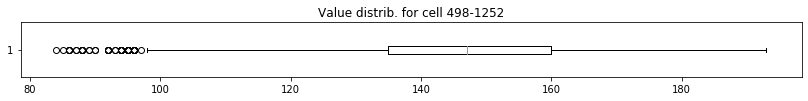

9008
Mean Absolute Error =  5.378095300671413


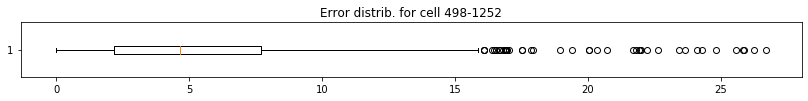

205


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


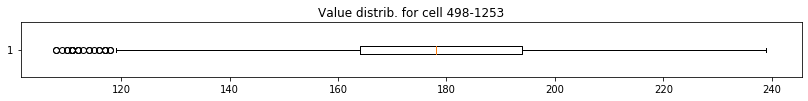

9008
Mean Absolute Error =  6.266002061917343


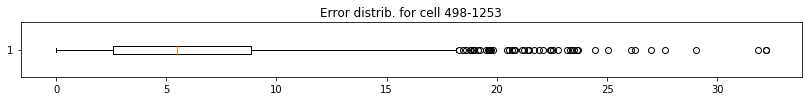

206


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


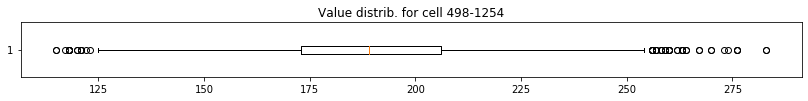

9008
Mean Absolute Error =  7.337175135925216


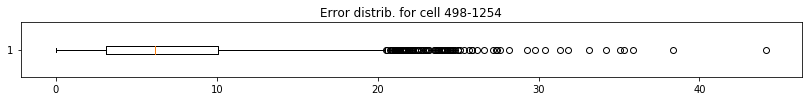

207


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


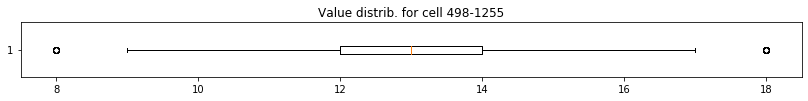

9008
Mean Absolute Error =  0.5247134648494979


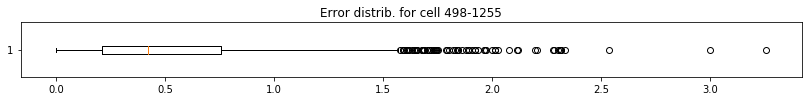

208


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


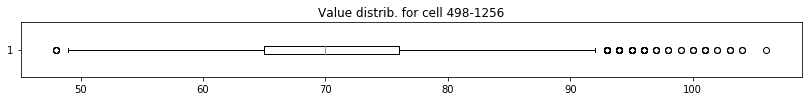

9008
Mean Absolute Error =  2.6285191513925863


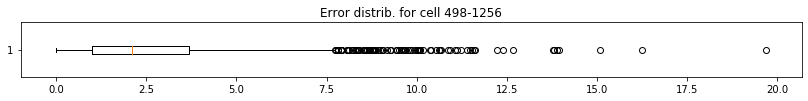

209


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


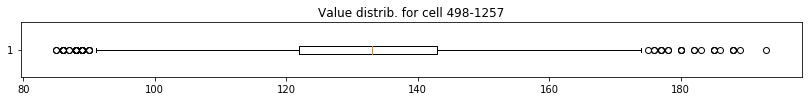

9008
Mean Absolute Error =  4.635707489727209


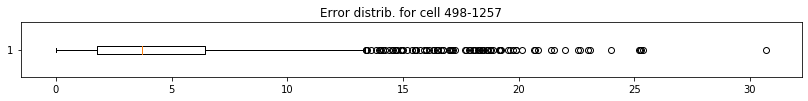

210


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


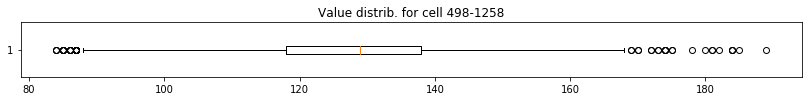

9008
Mean Absolute Error =  4.530122894455882


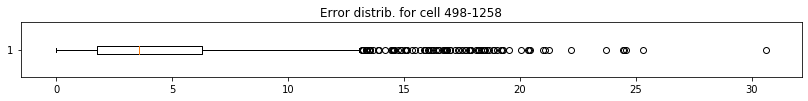

211


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


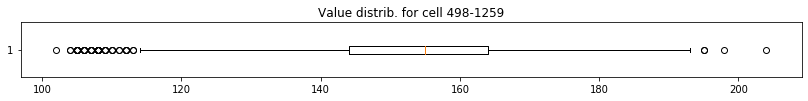

9008
Mean Absolute Error =  4.934669662412966


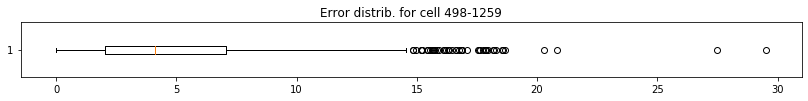

212


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


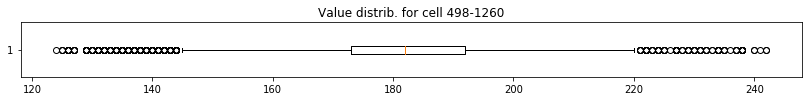

9008
Mean Absolute Error =  8.712565276770107


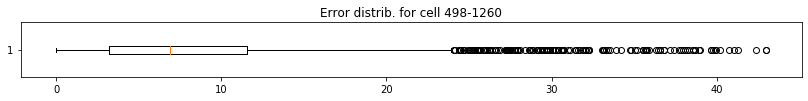

213


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


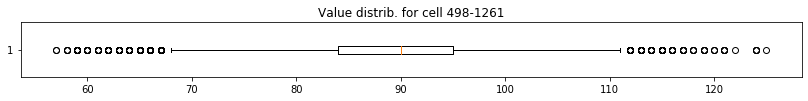

9008
Mean Absolute Error =  2.9403183669315935


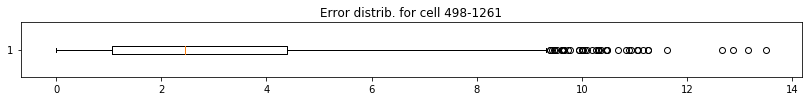

214


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


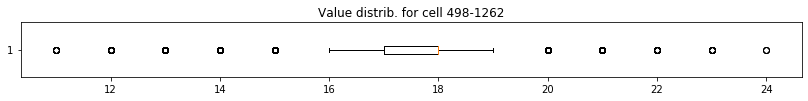

9008
Mean Absolute Error =  0.6078422373846237


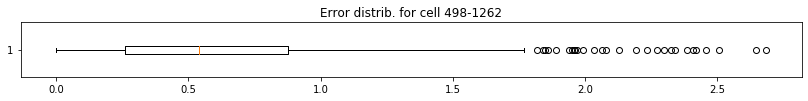

215


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


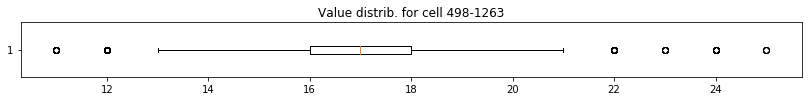

9008
Mean Absolute Error =  0.6658270256798147


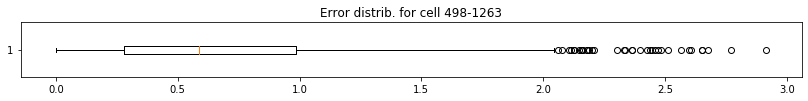

216


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


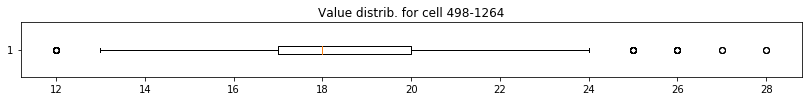

9008
Mean Absolute Error =  1.2178441404519225


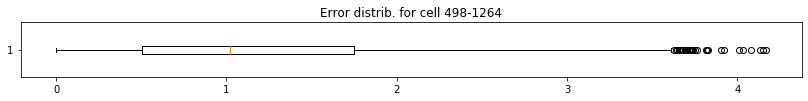

217


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


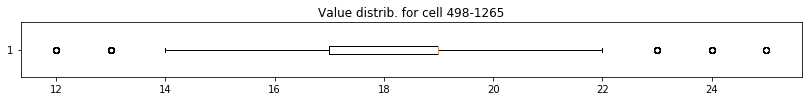

9008
Mean Absolute Error =  0.6523869865247989


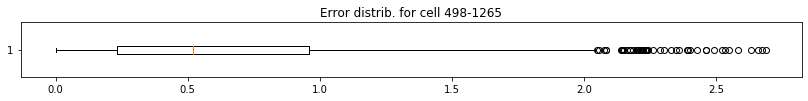

218


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


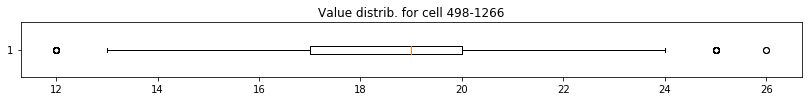

9008
Mean Absolute Error =  0.653837938830592


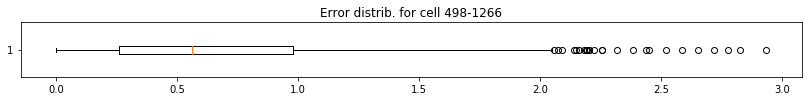

219


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


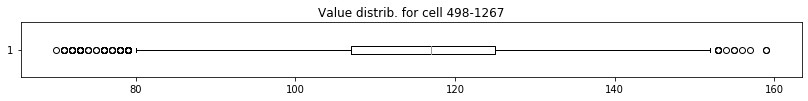

9008
Mean Absolute Error =  4.961705669379072


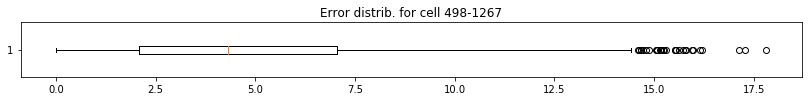

220


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


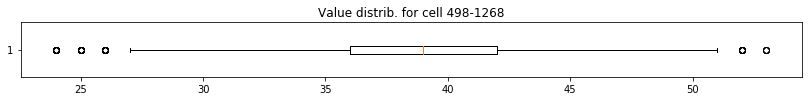

9008
Mean Absolute Error =  1.7689662519635119


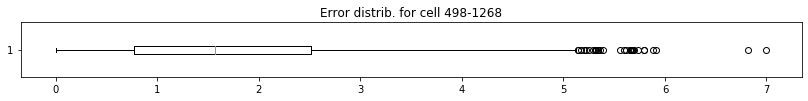

In [24]:
counter = 0
dict2data = {}
dict2MAPE = {}
error_list = []
for i,k in agg_by_cell: 
    
    cell = i
    print(counter)
    counter +=1
    dates4prophet = []
    cell_values = []
    
    for index, row in k.iterrows():
    
        date = row['date']
        h = str(row['hours'])
   
        h = h.split('.')
    
        if len(h[0])<2:
            h = h[1]+h[0]
        else: 
            h = h[0]
   
        minutes = str(row['minutes'])
        m = ''
        minutes = minutes.split('.')
        if len(minutes[0])<2: 
            m = minutes[0] +'0'
        else: 
            m = minutes[0]
        #print(date, h, m)
        data_f = date+' '+h+':'+m+':'+'00'
        #print(data_f)
        cell_values.append(row['nr_people'])
        dates4prophet.append(data_f)    
    
    # build data for prophet
    dict_i = {'ds': dates4prophet, 'y':cell_values}
    data4prophet = pd.DataFrame(dict_i)
    

    # fit the model
    m = Prophet(changepoint_prior_scale=0.01).fit(data4prophet)
    
    # make predictions
    future = m.make_future_dataframe(periods=0, freq='H')
    
    # make forcast.. 
    fcast = m.predict(future)
    
    # visualize cell values
    plt.figure(figsize = (14,1))
    plt.title('Value distrib. for cell '+str(i)) 
    plt.boxplot(cell_values, vert= False);
    plt.show()
    
    # compute difference between predicted and real value 
    
    #yhat = np.rint(fcst['yhat'].values)
    #max_element_in_cell = max(cell_values)
    difference = np.array([])
    
    steps_forcasting = 2800
    divide = len(data4prophet) - steps_forcasting
    print(divide)
    yhat = fcast[divide:]
    data4prophet_y = data4prophet[divide:]
    y = data4prophet_y['y'].values
    yhat = yhat['yhat'].values
    difference = abs(y - yhat)
    
    # ..and visualize plot
    plt.figure(figsize = (14,1))
    plt.title('Error distrib. for cell '+str(i)) 
    plt.boxplot(difference, vert= False);
    print('Mean Absolute Error = ', np.mean(difference))
    plt.show()
    MAPE = np.mean(abs(100 * (difference/y)))
    # collect data 2 dictionary
    minimum = np.amin(difference)   
    per75 = np.percentile(difference, 75)
    per50 = np.percentile(difference, 50)
    per25 = np.percentile(difference, 25)
    maximum = np.amax(difference)
    l5i = [minimum, per25, per50, per75, maximum]
    dict2data[cell] = l5i
    dict2MAPE[cell] = MAPE
    error_i = np.mean(difference)
    error_list.append(error_i)

In [27]:
with open('error_data_4_Prophet_prediction.csv', 'w') as f:
    for key, value in dict2data.items():
        f.write('%s:%s\n' % (key, value))
        
with open('error_data_4_MAPE_Prophet_prediction.csv', 'w') as f:
    for key, value in dict2MAPE.items():
        f.write('%s:%s\n' % (key, value))        